In [1]:
import h5py
import pylab as pl
import numpy as np
import matplotlib.colors as mpc
import networkx
import ipyvolume as ipv
import progressbar
import astropy.cosmology as apc
from sphviewer.tools import QuickView
from sphviewer.tools import Blend
import scipy.stats as sp

In [2]:
def split_unique_id(unique_id):
    """Splits the ids assign to the subhalos by the merger tree code by snap number and subfind number """
    subfind_number = int(unique_id % 1e6)
    snap_number = int((unique_id - subfind_number) / 1e6)
    
    return snap_number, subfind_number

def get_main_branch_unique_ids(subtree, node):
    """Gets the unique ids of the subhalos belonging to the main branch of the selected subhalo (node)"""
    mpb = [node, ]
    i = 0
    while True:
        succesors = list(subtree.successors(node))
        if len(succesors) == 0:
            break
        node = succesors[0] # select only the first succesor (main branch)
        mpb.append(node)
        
    return mpb

def get_main_branch_backwards(subtree, node):
    """Gets the unique ids of the subhalos belonging to the main branch of the selected subhalo (node)"""
    mpb = [node, ]
    i = 0
    while True:
        succesors = list(subtree.successors(node))
        if len(succesors) == 0: # i hope this still work
            break
        snap, idd = split_unique_id(int(node))
        snapT = str(snap-1)
        for s in succesors:
            if s.startswith(snapT):
                node = s # select the firts succesor from a previous snapshot
                break
        #node = succesors[0] # select only the first succesor (main branch)
        mpb.append(node)
        
    return mpb

In [3]:
pl.rc('font', size = 20)
pl.rc('legend', fontsize = 20)
sim = h5py.File('/data/cielo/simulations/LG1/LG1.hdf5', 'r')
trees = networkx.read_multiline_adjlist('/data/cielo/simulations/LG1/LG1_tree.dat')

In [4]:
Cosmo = apc.FlatLambdaCDM(H0=100, Om0=0.3175)

In [5]:
# a bunch of constants
UnitMass_in_g = 1.989e+43
UnitTime_in_s = 3.08568e+16
UnitVelocity_in_cm_per_s = 100000
UnitDensity_in_cgs = 6.7699e-22
UnitEnergy_in_cgs = 1.989e+53
GAMMA_MINUS1 = 2./3.
PROTONMASS = 1.6726e-24
BOLTZMANN = 1.3806e-16    

HMass = 1.00794
FeMass = 55.845
OMass = 15.9994
NfeNhe_sun = -4.5 # grevesse & saundall 98
NoNfe_sun = 1.33 # same

def tempFromMass(Mass, Abund, IE, ne1):
    XH = Abund[:,6]/Mass
    yHelium = (1. - XH)/(4.*XH)
    mu = (1 + 4.* yHelium)/ (1.+ yHelium + ne1 )
    temp = GAMMA_MINUS1 * IE * mu * 1.6726 / 1.3806 * 1.e-8 # / BOLTZMANN  * PROTONMASS
    temp = temp * 1e10 #   UnitEnergy_in_cgs / UnitMass_in_g;
    return temp

In [6]:
TdayTotalIDs = sim['SnapNumber_128/PartType0/ParticleIDs'][()] # need this first
TdayTotalStars = sim['SnapNumber_128/PartType4/ParticleIDs'][()] # need this first
I= np.identity(3) # and this

In [7]:
# and now to locate the firts pericentre, and the distance to the centre.
def getperi(gal, center):
    uniqueID = int(128*1e6+gal)
    stree = networkx.dfs_tree(trees, str(uniqueID))
    mtree = get_main_branch_unique_ids(stree, str(uniqueID))
    
    uniqueIDC = int(128*1e6+center)
    streeC = networkx.dfs_tree(trees, str(uniqueIDC))
    mtreeC = get_main_branch_unique_ids(streeC, str(uniqueIDC))
    
    r, thesnap, rphys = [], [], []
    
    proy = []
    iddS, iddSC = [], []
    for m, mC in zip(mtree, mtreeC):
        snap, idd = split_unique_id(int(m))
        snapC, iddC = split_unique_id(int(mC))
        
        group = sim['SnapNumber_{}/SubGroups/GroupNumber'.format(snap)][iddC]
        r200 = sim['SnapNumber_{}/Groups/Group_R_Crit200'.format(snap)][group]

        galPos = sim['SnapNumber_{}/SubGroups/SubGroupPos'.format(snap)][idd]
        cenPos = sim['SnapNumber_{}/SubGroups/SubGroupPos'.format(snap)][iddC]
        
        vec =  galPos - cenPos
        rad = np.sqrt(np.sum(vec**2.))
        
        r.append(rad/r200)
        rphys.append(rad)
        thesnap.append(snap)
        proy.append(vec)
        iddS.append(idd)
        iddSC.append(iddC)
        
    r, rphys, thesnap = np.array(r), np.array(rphys), np.array(thesnap)
    proy = np.array(proy)
    iddS, iddSC = np.array(iddS), np.array(iddSC)
    
    ir = np.where(r<2.) # no further, just in case
    
    r, rphys, thesnap = r[ir], rphys[ir], thesnap[ir]
    proy = proy[ir]
    iddS = iddS[ir]
    iddSC = iddSC[ir]
    
    angles = []
    for i in range(len(proy)-1):
        dot = np.dot(proy[i], proy[i-1])
        cos = dot/(rphys[i]*rphys[i-1])
        if cos>1 and cos<1.001: # a failsafe
            cos=1.
        angles.append(np.arccos(cos))
        
    angles = np.array(angles)
        
    # this is backwards, it starts in teh future and it moves formward.
    r, rphys, thesnap = np.flip(r), np.flip(rphys), np.flip(thesnap)
    
    angles = np.flip(angles)
    
    iddS = np.flip(iddS)
    
    pre, r0 = 0, rphys[0]
    for i, rr in enumerate(rphys[1:]):
        if rr>r0:
            break
        else:
            r0 = rr
            pre = i+1
            
            
    physD, Snap , theID, theIDC = rphys[pre], thesnap[pre], iddS[pre], iddSC[pre]
    angles = angles[pre-1:]
    
    mmr = rphys.min()
    firstsnap = thesnap.min()
    Nturn = np.sum(angles)/(2.*np.pi)
    
    return physD, Snap, mmr, firstsnap, Nturn, theID, theIDC

In [8]:
# let's try this
gal, center = 4470, 4469
physD, Snap, mmr, firstsnap, Nturn, theID, theIDC = getperi(gal, center)

firstsnap, Snap, Nturn, theID, theIDC

(97, 101, 0.9278289839658819, 2491, 4497)

In [9]:
uniqueID = int(128*1e6+gal)
stree = networkx.dfs_tree(trees, str(uniqueID))
mtree = get_main_branch_unique_ids(stree, str(uniqueID))
    
uniqueIDC = int(128*1e6+center)
streeC = networkx.dfs_tree(trees, str(uniqueIDC))
mtreeC = get_main_branch_unique_ids(streeC, str(uniqueIDC))
    
x, y, z = [], [], []
for m, mC in zip(mtree, mtreeC):
    snap, idd = split_unique_id(int(m))
    snapC, iddC = split_unique_id(int(mC))
        
    galPos = sim['SnapNumber_{}/SubGroups/SubGroupPos'.format(snap)][idd]
    cenPos = sim['SnapNumber_{}/SubGroups/SubGroupPos'.format(snap)][iddC]
        
    vec =  galPos - cenPos
    
    x.append(vec[0])
    y.append(vec[1])
    z.append(vec[2])
    
    if snap==Snap:
        x0, y0, z0 = vec[0], vec[1], vec[2]
        
x, y, z = np.array(x), np.array(y), np.array(z)

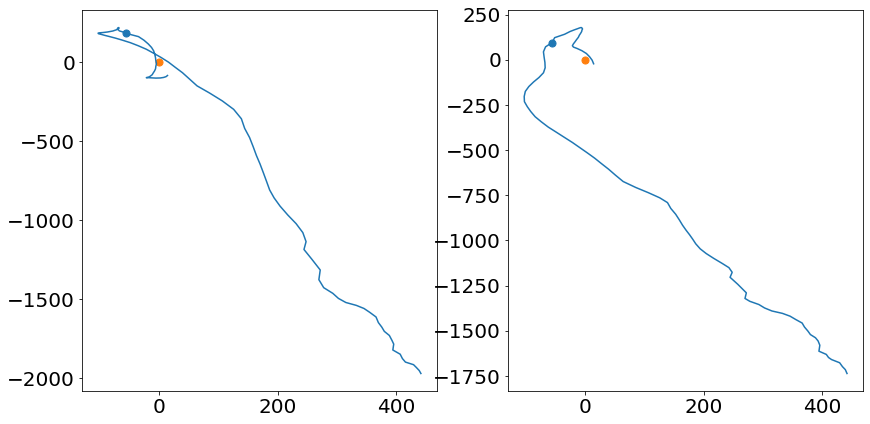

In [10]:
pl.figure(figsize=(14, 7))

pl.subplot(1, 2, 1)

pl.plot(x, y)
pl.scatter(x0, y0, marker='o', s=50)
pl.scatter(0, 0, marker='o', s=50)


pl.subplot(1, 2, 2)

pl.plot(x, z)
pl.scatter(x0, z0, marker='o', s=50)
pl.scatter(0, 0, marker='o', s=50)

In [11]:
# ok, lets do a new version of the thing that measures the thing by snapshot, and return mass and stuff
def getAllLastP(fofID, centralID, TheSnap):
    """
    get position, masses and abundances of all particles that in past snapshot belong to a given subhalo,
    and a z=0 are located at athe maximum distance of 600 kpc to the subhalo,
    rotated by the velocity and the vector to the centre.
    """
    uniqueID = int(TheSnap*1e6+fofID)
    stree = networkx.dfs_tree(trees, str(uniqueID))
#     mtree = get_main_branch_unique_ids(stree, str(uniqueID))
    mtree = get_main_branch_backwards(stree, str(uniqueID))
    
    TdayTotalIDs = sim['SnapNumber_{}/PartType0/ParticleIDs'.format(TheSnap)][()]
    
    #firts find all the particleIDs that once belong to the subgroup
    Idlist = []
    templist = []
    templist2 = []

    
    for mm in mtree[1:]: # ignore the first one
        snap, idd = split_unique_id(int(mm))
        tempOff = sim['SnapNumber_{}/SubGroups/PartType0/Offsets'.format(snap)][idd].astype('int')
        if tempOff[0]>= 0 and tempOff[1]>=0:
            tempIds = sim['SnapNumber_{}/PartType0/ParticleIDs'.format(snap)][tempOff[0]:tempOff[1]]
#             # and the temperature
#             IE = sim['SnapNumber_{}/PartType0/InternalEnergy'.format(snap)][tempOff[0]:tempOff[1]]
#             Mass = sim['SnapNumber_{}/PartType0/Masses'.format(snap)][tempOff[0]:tempOff[1]]
#             Abund = sim['SnapNumber_{}/PartType0/Abundances'.format(snap)][tempOff[0]:tempOff[1]]
#             ne1 = sim['SnapNumber_{}/PartType0/ElectronAbundance'.format(snap)][tempOff[0]:tempOff[1]]
#             val2 = tempFromMass(Mass, Abund, IE, ne1)
#             templist2.extend(list(val2))
            # and the metallicity
            AbundatTime = sim['SnapNumber_{}/PartType0/Abundances'.format(snap)][tempOff[0]:tempOff[1]]
            val = np.log10((AbundatTime[:,4]/FeMass)/(AbundatTime[:,6]/HMass)) - NfeNhe_sun
#             val = (AbundatTime[:,4]/FeMass)/(AbundatTime[:,6]/HMass)
            templist.extend(list(val))
            val2 = np.log10((AbundatTime[:,3]/OMass)/(AbundatTime[:,4]/FeMass)) - NoNfe_sun
            templist2.extend(list(val2))
            #zz = sim['SnapNumber_{}/Header/Redshift'.format(snap)][()]
            #templist.extend([zz]*tempIds.size)
            Idlist.extend(list(tempIds))

    Idlist = np.array(Idlist)
    templist = np.array(templist)
    templist2 = np.array(templist2)
    
    Idlist, Idunique = np.unique(Idlist, return_index=True) # remove duplicates
    templist = templist[Idunique]
    templist2 = templist2[Idunique]
    
    TdayOff = sim['SnapNumber_{}/SubGroups/PartType0/Offsets'.format(TheSnap)][fofID].astype('int')
    
    IndexToday = np.in1d(TdayTotalIDs, Idlist)
    IndexToday_ = np.where(IndexToday)[0]
    
    # lets remove the ones that are not part of the group today.
    TdayIDs = sim['SnapNumber_{}/PartType0/ParticleIDs'.format(TheSnap)][TdayOff[0]:TdayOff[1]]

    IndexNot = np.in1d(Idlist, TdayIDs)
    IdNot = Idlist[np.where(IndexNot==False)[0]]

    IndexT = np.in1d(TdayTotalIDs, IdNot)
    IndexT_ = np.where(IndexT)[0]
    
    # and temperature
    SurvIds_ = TdayTotalIDs[IndexT_]
    iidex = np.in1d(Idlist, SurvIds_)
    iidex_ = np.where(iidex)[0]
    templist_, Idlist_ = templist[iidex_], Idlist[iidex_]
    templist2_ = templist2[iidex_]

    is1 = np.argsort(SurvIds_) # the target
    is2 = np.argsort(Idlist_)

    temporder = np.zeros(IndexT_.size)
    temporder[is1] = templist_[is2]
    
    temporder2 = np.zeros(IndexT_.size)
    temporder2[is1] = templist2_[is2]
    
    #now lets cut at  a certain distance
    #distance = 600 # distance in ckpc
    distance = 200 
    
    posGal = sim['SnapNumber_{}/SubGroups/SubGroupPos'.format(TheSnap)][fofID]
    posCen = sim['SnapNumber_{}/SubGroups/SubGroupPos'.format(TheSnap)][centralID]

    LostCoord = sim['SnapNumber_{}/PartType0/Coordinates'.format(TheSnap)][IndexT_]
    
    dx, dy, dz = LostCoord[:,0]-posGal[0], LostCoord[:,1]-posGal[1], LostCoord[:,2]-posGal[2]
    distToC = np.sqrt(dx**2+dy**2+dz**2)

    icut = np.where(distToC<distance)[0]
    IndexT_near = IndexT_[icut] # this is the final list of particles ids
    temporder_near = temporder[icut]
    temporder_near2 = temporder2[icut]
    
    LostNow = sim['SnapNumber_{}/PartType0/SubGroupNumber'.format(TheSnap)][IndexT_near]
    
    icut2 = np.where(LostNow==-1)[0] # idk, for now no
    IndexT_near = IndexT_near[icut2]
    temporder_near = temporder_near[icut2]
    temporder_near2 = temporder_near2[icut2]
    
    # ok, lest see velocity and stuff
    velCen = sim['SnapNumber_{}/SubGroups/SubGroupVel'.format(TheSnap)][centralID]
    velSat = sim['SnapNumber_{}/SubGroups/SubGroupVel'.format(TheSnap)][fofID]

    velRep = velSat - velCen
    
    GasMasses = sim['SnapNumber_{}/PartType0/Masses'.format(TheSnap)][IndexT_near]
    GassAbundances = sim['SnapNumber_{}/PartType0/Abundances'.format(TheSnap)][IndexT_near]
    
    NearCoord = sim['SnapNumber_{}/PartType0/Coordinates'.format(TheSnap)][IndexT_near]

#     IE0 = sim['SnapNumber_128/PartType0/InternalEnergy'][IndexT_near]
#     ne10 = sim['SnapNumber_128/PartType0/ElectronAbundance'][IndexT_near]
#     t0 = tempFromMass(GasMasses, GassAbundances, IE0, ne10)
    
#     temporder_near = temporder_near - t0
#     temporder_near = t0 # not so subtle replacement
    # first lets re-define coordinates in a galactocentric scheme.
    X, Y, Z = NearCoord[:,0] - posGal[0], NearCoord[:,1] - posGal[1], NearCoord[:,2] - posGal[2]
    xC, yC, zC = posCen[0] - posGal[0], posCen[1] - posGal[1], posCen[2] - posGal[2] # the direction of the centre from the galaxy
    
    # now define normalized vectors, for velocity and centre directions
    velX, velY, velZ = velRep[0], velRep[1], velRep[2]
    Vel = np.sqrt(velX**2 + velY**2 + velZ**2)
    Cen = np.sqrt(xC**2 + yC**2 + zC**2)

    velx, vely, velz = velX/Vel, velY/Vel, velZ/Vel
    xc, yc, zc = xC/Cen, yC/Cen, zC/Cen
    
    # Then, the rotations matrix are, for velocity
    faV = (1-velx)/(vely**2 + velz**2)
    VV = np.array([[0, vely, velz], [-vely, 0, 0], [-velz, 0, 0]])
    VV2 = np.matmul(VV, VV)

    RV = I + VV + VV2*faV
    
    # and for the direction to the centre
    faC = (1-xc)/(yc**2+zc**2)
    CC = np.array([[0, yc, zc], [-yc, 0, 0], [-zc, 0, 0]])
    CC2 = np.matmul(CC, CC)

    RC = I + CC + CC2*faC
    
    # lets calculate the rotated coordinates
    xRv, yRv, zRv = [], [], []
    xRc, yRc, zRc = [], [], []

    for x, y, z in zip(X, Y, Z):
        dV = np.matmul(RV, np.array([x, y, z]))
        dC = np.matmul(RC, np.array([x, y, z]))
    
        xRv.append(dV[0])
        yRv.append(dV[1])
        zRv.append(dV[2])
    
        xRc.append(dC[0])
        yRc.append(dC[1])
        zRc.append(dC[2])
    
    xRv, yRv, zRv = np.array(xRv), np.array(yRv), np.array(zRv)
    xRc, yRc, zRc = np.array(xRc), np.array(yRc), np.array(zRc)
    
    # now, I only need one number, the cos stuff
    cosC = xRc/np.sqrt(xRc**2.+yRc**2.+zRc**2.)
    cosV = xRv/np.sqrt(xRv**2.+yRv**2.+zRv**2.)
    
    # and return the 2 sets of rotated positions, masses and abundances
    return cosV, cosC, GasMasses, GassAbundances, temporder_near, temporder_near2

In [12]:
# lest try this shitty thing
gal, cen = 4338, 4337

physD, Snap, mmr, firstsnap, Nturn, theID, theIDC = getperi(gal, cen)
cosV, cosC, GasMasses, GassAbundances, temporder_near, temporder_near2 = getAllLastP(theID, theIDC, Snap)

offST = sim['SnapNumber_{}/SubGroups/PartType4/Offsets'.format(Snap)][theID].astype('int')
stars = sim['SnapNumber_{}/PartType4/Masses'.format(Snap)][offST[0]:offST[1]]
SMass = np.sum(stars)

/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:35: RuntimeWarning: divide by zero encountered in log10
/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:38: RuntimeWarning: invalid value encountered in true_divide


Text(0, 0.5, 'Gas Mass/Stellar Mass')

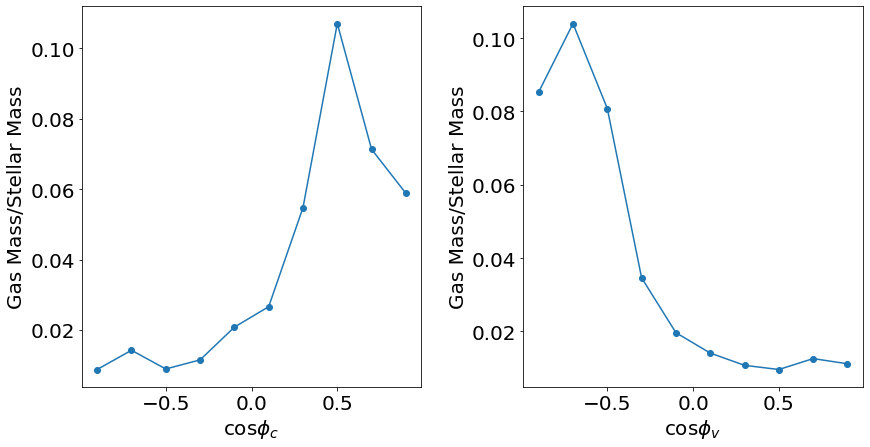

In [13]:
pl.figure(figsize=(14, 7))

pl.subplots_adjust(wspace=0.3)

sumC, binsC, zipC = sp.binned_statistic(cosC, GasMasses/SMass, statistic='sum', bins=10, range=(-1.,1.))
sumV, binsV, zipV = sp.binned_statistic(cosV, GasMasses/SMass, statistic='sum', bins=10, range=(-1.,1.))

x_x = .5*(binsV[:-1]+binsV[1:])

pl.subplot(1, 2, 1)

pl.plot(x_x, sumC, marker='o')

pl.xlabel('$\cos \phi_c$')
pl.ylabel('Gas Mass/Stellar Mass')

pl.subplot(1, 2, 2)

pl.errorbar(x_x, sumV, marker='o')

pl.xlabel('$\cos \phi_v$')
pl.ylabel('Gas Mass/Stellar Mass')

Text(0, 0.5, '[Fe/H]')

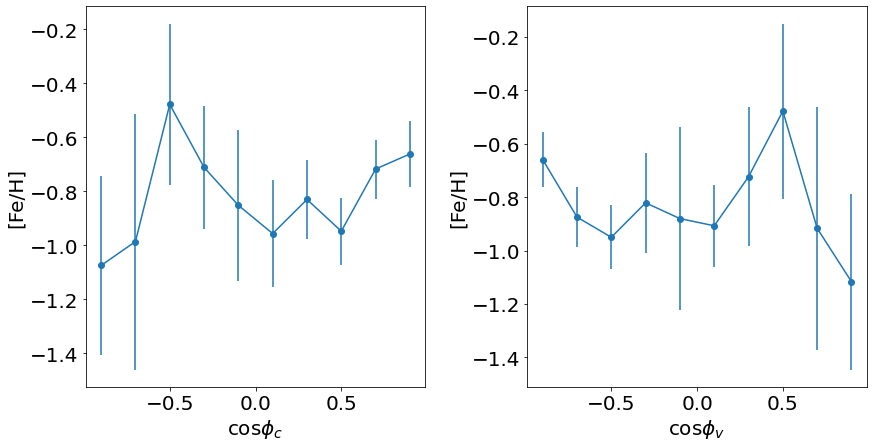

In [14]:
pl.figure(figsize=(14, 7))

pl.subplots_adjust(wspace=0.3)

inn = np.where((np.isnan(temporder_near)==False) & (np.isinf(temporder_near)==False))

cosC_ = cosC[inn]
cosV_ = cosV[inn]
temp = temporder_near[inn]

sumC, binsC, zipC = sp.binned_statistic(cosC_, temp, statistic='median', bins=10, range=(-1.,1.))
sumV, binsV, zipV = sp.binned_statistic(cosV_, temp, statistic='median', bins=10, range=(-1.,1.))

stdC, binsC, zipC = sp.binned_statistic(cosC_, temp, statistic='std', bins=10, range=(-1.,1.))
stdV, binsV, zipV = sp.binned_statistic(cosV_, temp, statistic='std', bins=10, range=(-1.,1.))

numbC, binsC, zipC = sp.binned_statistic(cosC_, temp, statistic='count', bins=10, range=(-1.,1.))
numbV, binsV, zipV = sp.binned_statistic(cosV_, temp, statistic='count', bins=10, range=(-1.,1.))

errC = stdC/np.sqrt(numbC) * np.sqrt(np.pi/2.)
errV = stdV/np.sqrt(numbV) * np.sqrt(np.pi/2.)

x_x = .5*(binsV[:-1]+binsV[1:])

pl.subplot(1, 2, 1)

pl.errorbar(x_x, sumC, yerr=errC, marker='o')

pl.xlabel('$\cos \phi_c$')
pl.ylabel('[Fe/H]')

pl.subplot(1, 2, 2)

pl.errorbar(x_x, sumV, yerr=errV, marker='o')

pl.xlabel('$\cos \phi_v$')
pl.ylabel('[Fe/H]')

Text(0, 0.5, '[O/Fe]')

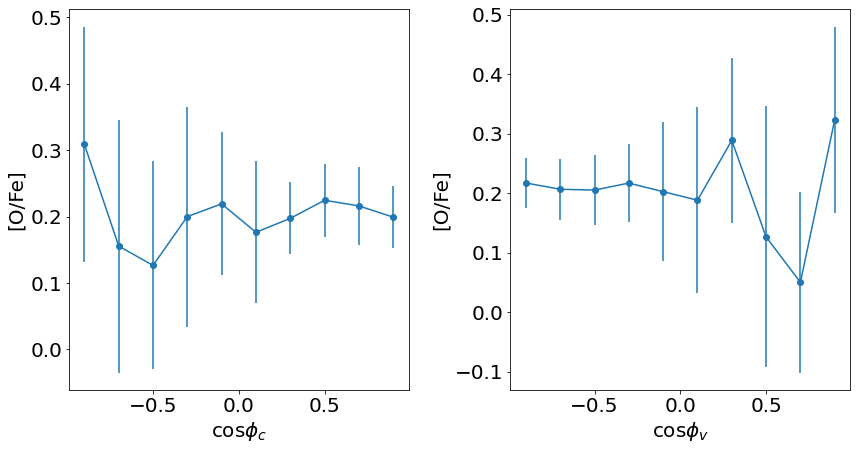

In [15]:
pl.figure(figsize=(14, 7))

pl.subplots_adjust(wspace=0.3)

inn = np.where((np.isnan(temporder_near2)==False) & (np.isinf(temporder_near2)==False))

cosC_ = cosC[inn]
cosV_ = cosV[inn]
temp = temporder_near2[inn]

sumC, binsC, zipC = sp.binned_statistic(cosC_, temp, statistic='median', bins=10, range=(-1.,1.))
sumV, binsV, zipV = sp.binned_statistic(cosV_, temp, statistic='median', bins=10, range=(-1.,1.))

stdC, binsC, zipC = sp.binned_statistic(cosC_, temp, statistic='std', bins=10, range=(-1.,1.))
stdV, binsV, zipV = sp.binned_statistic(cosV_, temp, statistic='std', bins=10, range=(-1.,1.))

numbC, binsC, zipC = sp.binned_statistic(cosC_, temp, statistic='count', bins=10, range=(-1.,1.))
numbV, binsV, zipV = sp.binned_statistic(cosV_, temp, statistic='count', bins=10, range=(-1.,1.))

errC = stdC/np.sqrt(numbC) * np.sqrt(np.pi/2.)
errV = stdV/np.sqrt(numbV) * np.sqrt(np.pi/2.)

x_x = .5*(binsV[:-1]+binsV[1:])

pl.subplot(1, 2, 1)

pl.errorbar(x_x, sumC, yerr=errC, marker='o')

pl.xlabel('$\cos \phi_c$')
pl.ylabel('[O/Fe]')

pl.subplot(1, 2, 2)

pl.errorbar(x_x, sumV, yerr=errV, marker='o')

pl.xlabel('$\cos \phi_v$')
pl.ylabel('[O/Fe]')

/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:35: RuntimeWarning: divide by zero encountered in log10
/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:38: RuntimeWarning: invalid value encountered in true_divide
/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in true_divide
/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:92: RuntimeWarning: invalid value encountered in true_divide


Text(0, 0.5, '[O/Fe]')

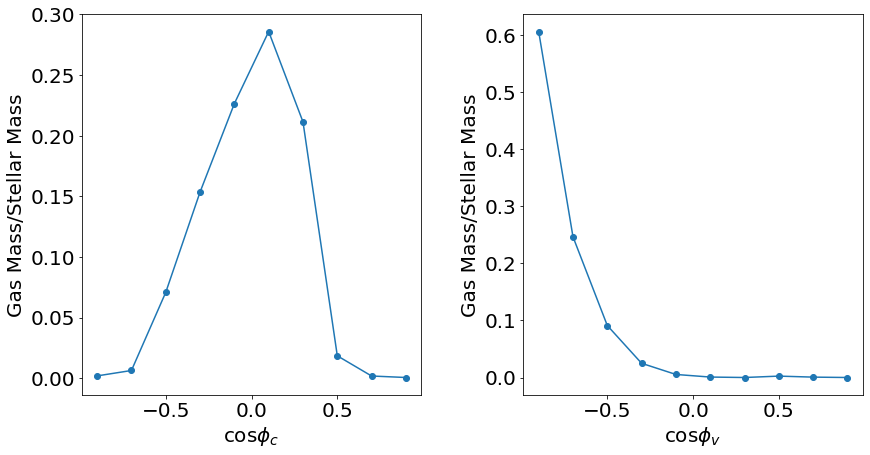

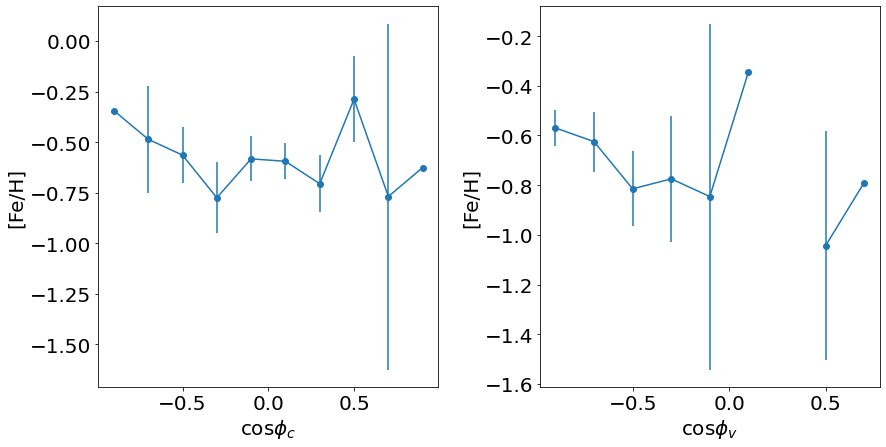

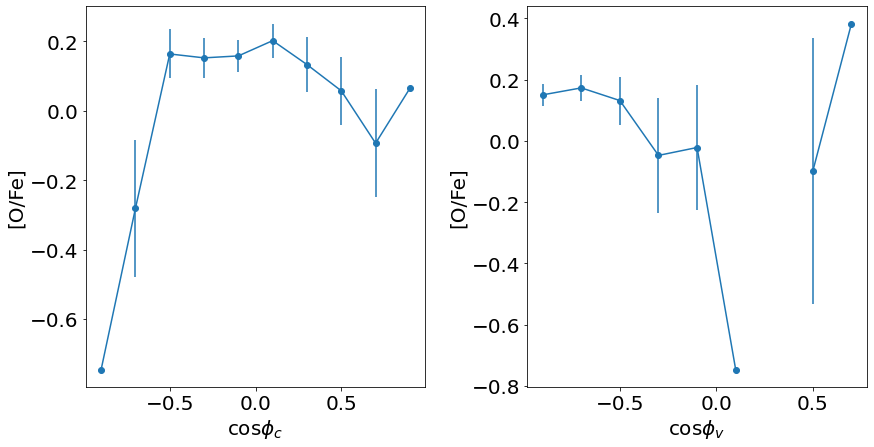

In [16]:
# lest try this shitty thing
gal, cen = 4339, 4337

physD, Snap, mmr, firstsnap, Nturn, theID, theIDC = getperi(gal, cen)
cosV, cosC, GasMasses, GassAbundances, temporder_near, temporder_near2 = getAllLastP(theID, theIDC, Snap)

offST = sim['SnapNumber_{}/SubGroups/PartType4/Offsets'.format(Snap)][theID].astype('int')
stars = sim['SnapNumber_{}/PartType4/Masses'.format(Snap)][offST[0]:offST[1]]
SMass = np.sum(stars)

pl.figure(figsize=(14, 7))

pl.subplots_adjust(wspace=0.3)

sumC, binsC, zipC = sp.binned_statistic(cosC, GasMasses/SMass, statistic='sum', bins=10, range=(-1.,1.))
sumV, binsV, zipV = sp.binned_statistic(cosV, GasMasses/SMass, statistic='sum', bins=10, range=(-1.,1.))

x_x = .5*(binsV[:-1]+binsV[1:])

pl.subplot(1, 2, 1)

pl.plot(x_x, sumC, marker='o')

pl.xlabel('$\cos \phi_c$')
pl.ylabel('Gas Mass/Stellar Mass')

pl.subplot(1, 2, 2)

pl.errorbar(x_x, sumV, marker='o')

pl.xlabel('$\cos \phi_v$')
pl.ylabel('Gas Mass/Stellar Mass')

pl.figure(figsize=(14, 7))

pl.subplots_adjust(wspace=0.3)

inn = np.where((np.isnan(temporder_near)==False) & (np.isinf(temporder_near)==False))

cosC_ = cosC[inn]
cosV_ = cosV[inn]
temp = temporder_near[inn]

sumC, binsC, zipC = sp.binned_statistic(cosC_, temp, statistic='median', bins=10, range=(-1.,1.))
sumV, binsV, zipV = sp.binned_statistic(cosV_, temp, statistic='median', bins=10, range=(-1.,1.))

stdC, binsC, zipC = sp.binned_statistic(cosC_, temp, statistic='std', bins=10, range=(-1.,1.))
stdV, binsV, zipV = sp.binned_statistic(cosV_, temp, statistic='std', bins=10, range=(-1.,1.))

numbC, binsC, zipC = sp.binned_statistic(cosC_, temp, statistic='count', bins=10, range=(-1.,1.))
numbV, binsV, zipV = sp.binned_statistic(cosV_, temp, statistic='count', bins=10, range=(-1.,1.))

errC = stdC/np.sqrt(numbC) * np.sqrt(np.pi/2.)
errV = stdV/np.sqrt(numbV) * np.sqrt(np.pi/2.)

x_x = .5*(binsV[:-1]+binsV[1:])

pl.subplot(1, 2, 1)

pl.errorbar(x_x, sumC, yerr=errC, marker='o')

pl.xlabel('$\cos \phi_c$')
pl.ylabel('[Fe/H]')

pl.subplot(1, 2, 2)

pl.errorbar(x_x, sumV, yerr=errV, marker='o')

pl.xlabel('$\cos \phi_v$')
pl.ylabel('[Fe/H]')

pl.figure(figsize=(14, 7))

pl.subplots_adjust(wspace=0.3)

inn = np.where((np.isnan(temporder_near2)==False) & (np.isinf(temporder_near2)==False))

cosC_ = cosC[inn]
cosV_ = cosV[inn]
temp = temporder_near2[inn]

sumC, binsC, zipC = sp.binned_statistic(cosC_, temp, statistic='median', bins=10, range=(-1.,1.))
sumV, binsV, zipV = sp.binned_statistic(cosV_, temp, statistic='median', bins=10, range=(-1.,1.))

stdC, binsC, zipC = sp.binned_statistic(cosC_, temp, statistic='std', bins=10, range=(-1.,1.))
stdV, binsV, zipV = sp.binned_statistic(cosV_, temp, statistic='std', bins=10, range=(-1.,1.))

numbC, binsC, zipC = sp.binned_statistic(cosC_, temp, statistic='count', bins=10, range=(-1.,1.))
numbV, binsV, zipV = sp.binned_statistic(cosV_, temp, statistic='count', bins=10, range=(-1.,1.))

errC = stdC/np.sqrt(numbC) * np.sqrt(np.pi/2.)
errV = stdV/np.sqrt(numbV) * np.sqrt(np.pi/2.)

x_x = .5*(binsV[:-1]+binsV[1:])

pl.subplot(1, 2, 1)

pl.errorbar(x_x, sumC, yerr=errC, marker='o')

pl.xlabel('$\cos \phi_c$')
pl.ylabel('[O/Fe]')

pl.subplot(1, 2, 2)

pl.errorbar(x_x, sumV, yerr=errV, marker='o')

pl.xlabel('$\cos \phi_v$')
pl.ylabel('[O/Fe]')

/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:35: RuntimeWarning: divide by zero encountered in log10
/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:38: RuntimeWarning: invalid value encountered in true_divide
/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:52: RuntimeWarning: invalid value encountered in true_divide
/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in true_divide
/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:90: RuntimeWarning: invalid value encountered in true_divide
/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:91: RuntimeWarning: invalid value encountered in true_divide


Text(0, 0.5, '[O/Fe]')

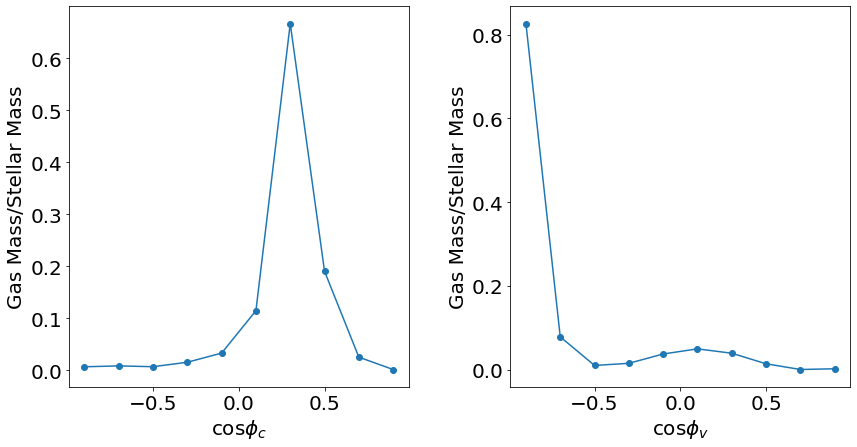

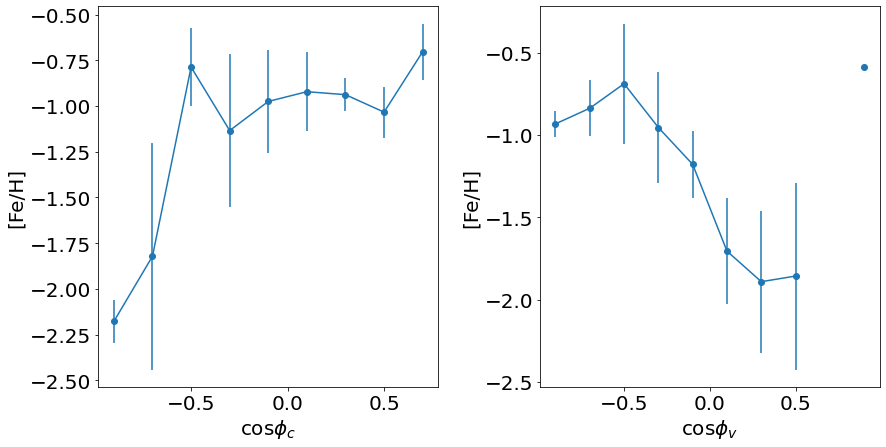

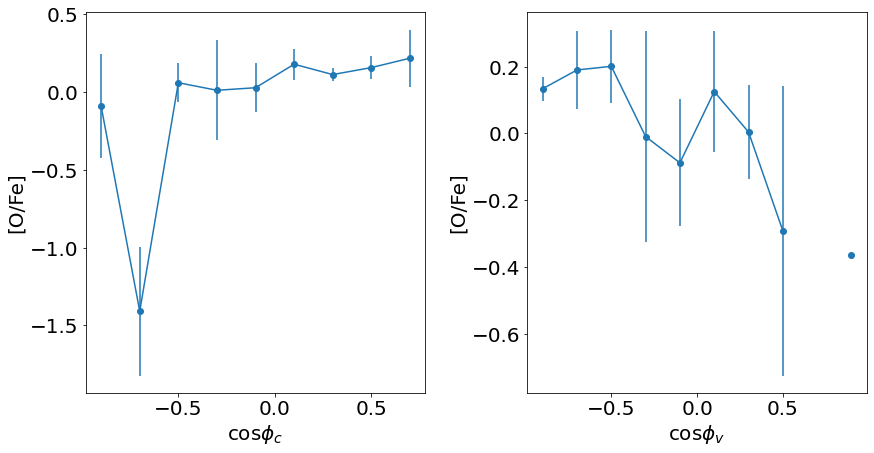

In [17]:
gal, cen = 4341, 4337

physD, Snap, mmr, firstsnap, Nturn, theID, theIDC = getperi(gal, cen)
cosV, cosC, GasMasses, GassAbundances, temporder_near, temporder_near2 = getAllLastP(theID, theIDC, Snap)

offST = sim['SnapNumber_{}/SubGroups/PartType4/Offsets'.format(Snap)][theID].astype('int')
stars = sim['SnapNumber_{}/PartType4/Masses'.format(Snap)][offST[0]:offST[1]]
SMass = np.sum(stars)

pl.figure(figsize=(14, 7))

pl.subplots_adjust(wspace=0.3)

sumC, binsC, zipC = sp.binned_statistic(cosC, GasMasses/SMass, statistic='sum', bins=10, range=(-1.,1.))
sumV, binsV, zipV = sp.binned_statistic(cosV, GasMasses/SMass, statistic='sum', bins=10, range=(-1.,1.))

x_x = .5*(binsV[:-1]+binsV[1:])

pl.subplot(1, 2, 1)

pl.plot(x_x, sumC, marker='o')

pl.xlabel('$\cos \phi_c$')
pl.ylabel('Gas Mass/Stellar Mass')

pl.subplot(1, 2, 2)

pl.errorbar(x_x, sumV, marker='o')

pl.xlabel('$\cos \phi_v$')
pl.ylabel('Gas Mass/Stellar Mass')

pl.figure(figsize=(14, 7))

pl.subplots_adjust(wspace=0.3)

inn = np.where((np.isnan(temporder_near)==False) & (np.isinf(temporder_near)==False))

cosC_ = cosC[inn]
cosV_ = cosV[inn]
temp = temporder_near[inn]

sumC, binsC, zipC = sp.binned_statistic(cosC_, temp, statistic='median', bins=10, range=(-1.,1.))
sumV, binsV, zipV = sp.binned_statistic(cosV_, temp, statistic='median', bins=10, range=(-1.,1.))

stdC, binsC, zipC = sp.binned_statistic(cosC_, temp, statistic='std', bins=10, range=(-1.,1.))
stdV, binsV, zipV = sp.binned_statistic(cosV_, temp, statistic='std', bins=10, range=(-1.,1.))

numbC, binsC, zipC = sp.binned_statistic(cosC_, temp, statistic='count', bins=10, range=(-1.,1.))
numbV, binsV, zipV = sp.binned_statistic(cosV_, temp, statistic='count', bins=10, range=(-1.,1.))

errC = stdC/np.sqrt(numbC) * np.sqrt(np.pi/2.)
errV = stdV/np.sqrt(numbV) * np.sqrt(np.pi/2.)

x_x = .5*(binsV[:-1]+binsV[1:])

pl.subplot(1, 2, 1)

pl.errorbar(x_x, sumC, yerr=errC, marker='o')

pl.xlabel('$\cos \phi_c$')
pl.ylabel('[Fe/H]')

pl.subplot(1, 2, 2)

pl.errorbar(x_x, sumV, yerr=errV, marker='o')

pl.xlabel('$\cos \phi_v$')
pl.ylabel('[Fe/H]')

pl.figure(figsize=(14, 7))

pl.subplots_adjust(wspace=0.3)

inn = np.where((np.isnan(temporder_near2)==False) & (np.isinf(temporder_near2)==False))

cosC_ = cosC[inn]
cosV_ = cosV[inn]
temp = temporder_near2[inn]

sumC, binsC, zipC = sp.binned_statistic(cosC_, temp, statistic='median', bins=10, range=(-1.,1.))
sumV, binsV, zipV = sp.binned_statistic(cosV_, temp, statistic='median', bins=10, range=(-1.,1.))

stdC, binsC, zipC = sp.binned_statistic(cosC_, temp, statistic='std', bins=10, range=(-1.,1.))
stdV, binsV, zipV = sp.binned_statistic(cosV_, temp, statistic='std', bins=10, range=(-1.,1.))

numbC, binsC, zipC = sp.binned_statistic(cosC_, temp, statistic='count', bins=10, range=(-1.,1.))
numbV, binsV, zipV = sp.binned_statistic(cosV_, temp, statistic='count', bins=10, range=(-1.,1.))

errC = stdC/np.sqrt(numbC) * np.sqrt(np.pi/2.)
errV = stdV/np.sqrt(numbV) * np.sqrt(np.pi/2.)

x_x = .5*(binsV[:-1]+binsV[1:])

pl.subplot(1, 2, 1)

pl.errorbar(x_x, sumC, yerr=errC, marker='o')

pl.xlabel('$\cos \phi_c$')
pl.ylabel('[O/Fe]')

pl.subplot(1, 2, 2)

pl.errorbar(x_x, sumV, yerr=errV, marker='o')

pl.xlabel('$\cos \phi_v$')
pl.ylabel('[O/Fe]')

/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:35: RuntimeWarning: divide by zero encountered in log10
/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:38: RuntimeWarning: invalid value encountered in true_divide
/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:52: RuntimeWarning: invalid value encountered in true_divide
/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in true_divide
/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:90: RuntimeWarning: invalid value encountered in true_divide
/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:91: RuntimeWarning: invalid value encountered in true_divide


Text(0, 0.5, '[O/Fe]')

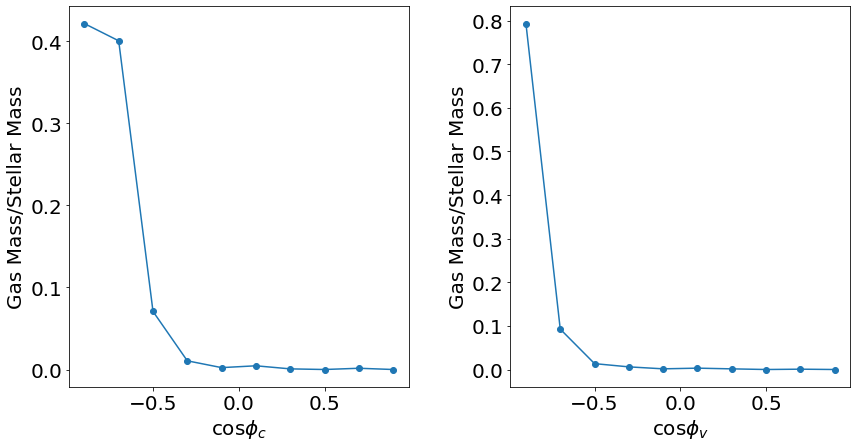

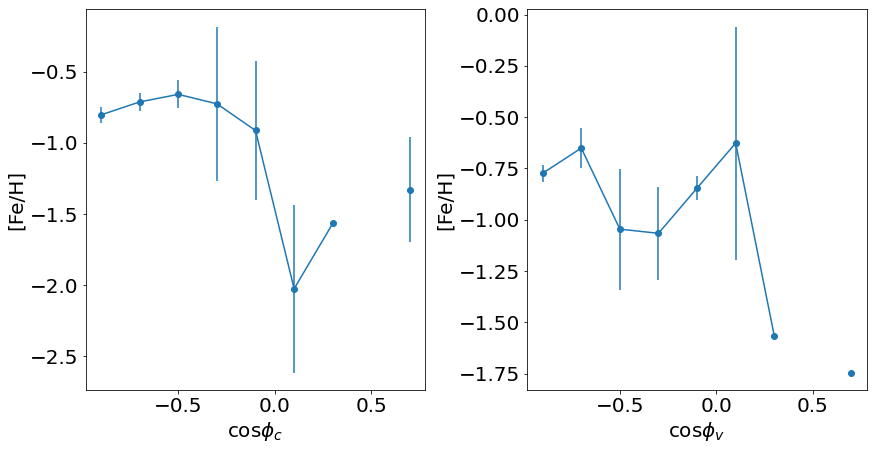

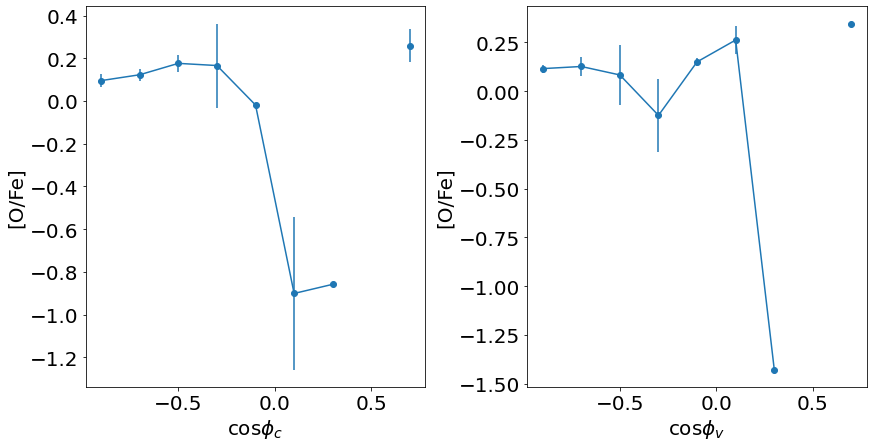

In [18]:
gal, cen = 4343, 4337

physD, Snap, mmr, firstsnap, Nturn, theID, theIDC = getperi(gal, cen)
cosV, cosC, GasMasses, GassAbundances, temporder_near, temporder_near2 = getAllLastP(theID, theIDC, Snap)

offST = sim['SnapNumber_{}/SubGroups/PartType4/Offsets'.format(Snap)][theID].astype('int')
stars = sim['SnapNumber_{}/PartType4/Masses'.format(Snap)][offST[0]:offST[1]]
SMass = np.sum(stars)

pl.figure(figsize=(14, 7))

pl.subplots_adjust(wspace=0.3)

sumC, binsC, zipC = sp.binned_statistic(cosC, GasMasses/SMass, statistic='sum', bins=10, range=(-1.,1.))
sumV, binsV, zipV = sp.binned_statistic(cosV, GasMasses/SMass, statistic='sum', bins=10, range=(-1.,1.))

x_x = .5*(binsV[:-1]+binsV[1:])

pl.subplot(1, 2, 1)

pl.plot(x_x, sumC, marker='o')

pl.xlabel('$\cos \phi_c$')
pl.ylabel('Gas Mass/Stellar Mass')

pl.subplot(1, 2, 2)

pl.errorbar(x_x, sumV, marker='o')

pl.xlabel('$\cos \phi_v$')
pl.ylabel('Gas Mass/Stellar Mass')

pl.figure(figsize=(14, 7))

pl.subplots_adjust(wspace=0.3)

inn = np.where((np.isnan(temporder_near)==False) & (np.isinf(temporder_near)==False))

cosC_ = cosC[inn]
cosV_ = cosV[inn]
temp = temporder_near[inn]

sumC, binsC, zipC = sp.binned_statistic(cosC_, temp, statistic='median', bins=10, range=(-1.,1.))
sumV, binsV, zipV = sp.binned_statistic(cosV_, temp, statistic='median', bins=10, range=(-1.,1.))

stdC, binsC, zipC = sp.binned_statistic(cosC_, temp, statistic='std', bins=10, range=(-1.,1.))
stdV, binsV, zipV = sp.binned_statistic(cosV_, temp, statistic='std', bins=10, range=(-1.,1.))

numbC, binsC, zipC = sp.binned_statistic(cosC_, temp, statistic='count', bins=10, range=(-1.,1.))
numbV, binsV, zipV = sp.binned_statistic(cosV_, temp, statistic='count', bins=10, range=(-1.,1.))

errC = stdC/np.sqrt(numbC) * np.sqrt(np.pi/2.)
errV = stdV/np.sqrt(numbV) * np.sqrt(np.pi/2.)

x_x = .5*(binsV[:-1]+binsV[1:])

pl.subplot(1, 2, 1)

pl.errorbar(x_x, sumC, yerr=errC, marker='o')

pl.xlabel('$\cos \phi_c$')
pl.ylabel('[Fe/H]')

pl.subplot(1, 2, 2)

pl.errorbar(x_x, sumV, yerr=errV, marker='o')

pl.xlabel('$\cos \phi_v$')
pl.ylabel('[Fe/H]')

pl.figure(figsize=(14, 7))

pl.subplots_adjust(wspace=0.3)

inn = np.where((np.isnan(temporder_near2)==False) & (np.isinf(temporder_near2)==False))

cosC_ = cosC[inn]
cosV_ = cosV[inn]
temp = temporder_near2[inn]

sumC, binsC, zipC = sp.binned_statistic(cosC_, temp, statistic='median', bins=10, range=(-1.,1.))
sumV, binsV, zipV = sp.binned_statistic(cosV_, temp, statistic='median', bins=10, range=(-1.,1.))

stdC, binsC, zipC = sp.binned_statistic(cosC_, temp, statistic='std', bins=10, range=(-1.,1.))
stdV, binsV, zipV = sp.binned_statistic(cosV_, temp, statistic='std', bins=10, range=(-1.,1.))

numbC, binsC, zipC = sp.binned_statistic(cosC_, temp, statistic='count', bins=10, range=(-1.,1.))
numbV, binsV, zipV = sp.binned_statistic(cosV_, temp, statistic='count', bins=10, range=(-1.,1.))

errC = stdC/np.sqrt(numbC) * np.sqrt(np.pi/2.)
errV = stdV/np.sqrt(numbV) * np.sqrt(np.pi/2.)

x_x = .5*(binsV[:-1]+binsV[1:])

pl.subplot(1, 2, 1)

pl.errorbar(x_x, sumC, yerr=errC, marker='o')

pl.xlabel('$\cos \phi_c$')
pl.ylabel('[O/Fe]')

pl.subplot(1, 2, 2)

pl.errorbar(x_x, sumV, yerr=errV, marker='o')

pl.xlabel('$\cos \phi_v$')
pl.ylabel('[O/Fe]')

/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:35: RuntimeWarning: divide by zero encountered in log10
/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:38: RuntimeWarning: invalid value encountered in true_divide


Text(0, 0.5, '[O/Fe]')

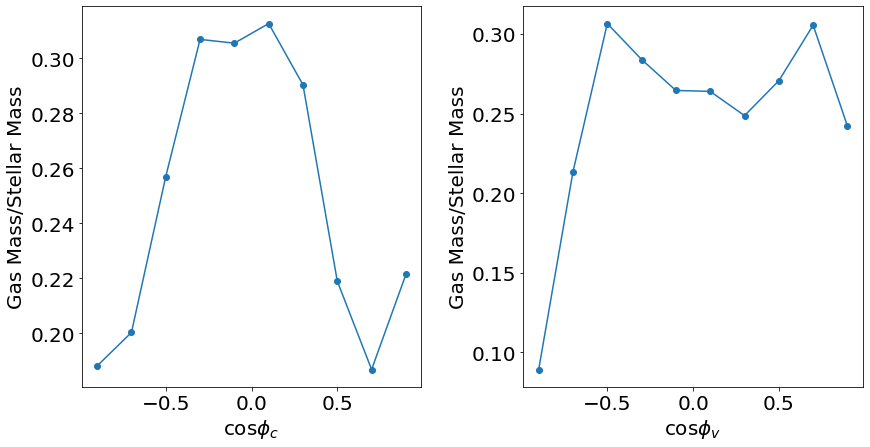

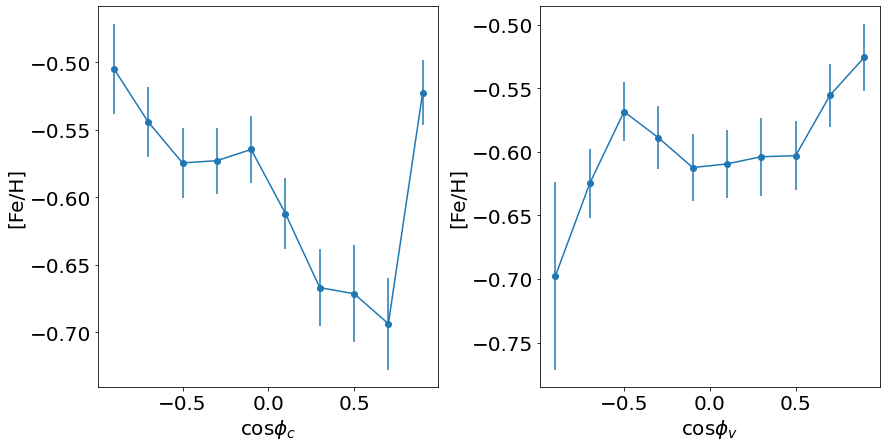

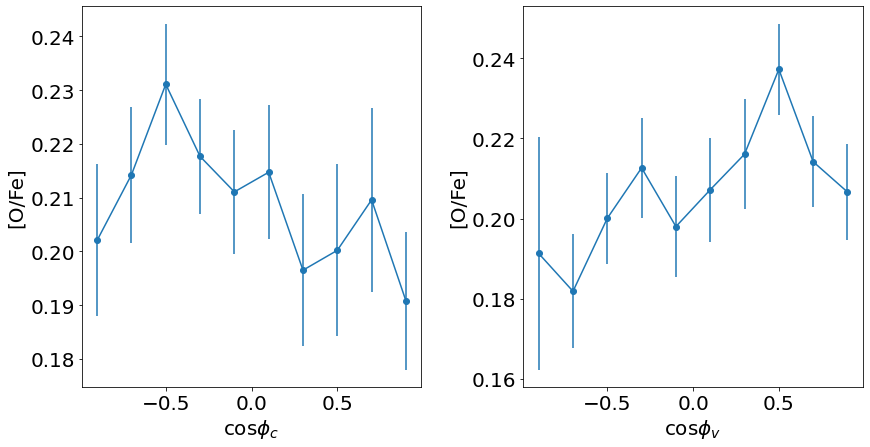

In [19]:
gal, cen = 4470, 4469

physD, Snap, mmr, firstsnap, Nturn, theID, theIDC = getperi(gal, cen)
cosV, cosC, GasMasses, GassAbundances, temporder_near, temporder_near2 = getAllLastP(theID, theIDC, Snap)

offST = sim['SnapNumber_{}/SubGroups/PartType4/Offsets'.format(Snap)][theID].astype('int')
stars = sim['SnapNumber_{}/PartType4/Masses'.format(Snap)][offST[0]:offST[1]]
SMass = np.sum(stars)

pl.figure(figsize=(14, 7))

pl.subplots_adjust(wspace=0.3)

sumC, binsC, zipC = sp.binned_statistic(cosC, GasMasses/SMass, statistic='sum', bins=10, range=(-1.,1.))
sumV, binsV, zipV = sp.binned_statistic(cosV, GasMasses/SMass, statistic='sum', bins=10, range=(-1.,1.))

x_x = .5*(binsV[:-1]+binsV[1:])

pl.subplot(1, 2, 1)

pl.plot(x_x, sumC, marker='o')

pl.xlabel('$\cos \phi_c$')
pl.ylabel('Gas Mass/Stellar Mass')

pl.subplot(1, 2, 2)

pl.errorbar(x_x, sumV, marker='o')

pl.xlabel('$\cos \phi_v$')
pl.ylabel('Gas Mass/Stellar Mass')

pl.figure(figsize=(14, 7))

pl.subplots_adjust(wspace=0.3)

inn = np.where((np.isnan(temporder_near)==False) & (np.isinf(temporder_near)==False))

cosC_ = cosC[inn]
cosV_ = cosV[inn]
temp = temporder_near[inn]

sumC, binsC, zipC = sp.binned_statistic(cosC_, temp, statistic='median', bins=10, range=(-1.,1.))
sumV, binsV, zipV = sp.binned_statistic(cosV_, temp, statistic='median', bins=10, range=(-1.,1.))

stdC, binsC, zipC = sp.binned_statistic(cosC_, temp, statistic='std', bins=10, range=(-1.,1.))
stdV, binsV, zipV = sp.binned_statistic(cosV_, temp, statistic='std', bins=10, range=(-1.,1.))

numbC, binsC, zipC = sp.binned_statistic(cosC_, temp, statistic='count', bins=10, range=(-1.,1.))
numbV, binsV, zipV = sp.binned_statistic(cosV_, temp, statistic='count', bins=10, range=(-1.,1.))

errC = stdC/np.sqrt(numbC) * np.sqrt(np.pi/2.)
errV = stdV/np.sqrt(numbV) * np.sqrt(np.pi/2.)

x_x = .5*(binsV[:-1]+binsV[1:])

pl.subplot(1, 2, 1)

pl.errorbar(x_x, sumC, yerr=errC, marker='o')

pl.xlabel('$\cos \phi_c$')
pl.ylabel('[Fe/H]')

pl.subplot(1, 2, 2)

pl.errorbar(x_x, sumV, yerr=errV, marker='o')

pl.xlabel('$\cos \phi_v$')
pl.ylabel('[Fe/H]')

pl.figure(figsize=(14, 7))

pl.subplots_adjust(wspace=0.3)

inn = np.where((np.isnan(temporder_near2)==False) & (np.isinf(temporder_near2)==False))

cosC_ = cosC[inn]
cosV_ = cosV[inn]
temp = temporder_near2[inn]

sumC, binsC, zipC = sp.binned_statistic(cosC_, temp, statistic='median', bins=10, range=(-1.,1.))
sumV, binsV, zipV = sp.binned_statistic(cosV_, temp, statistic='median', bins=10, range=(-1.,1.))

stdC, binsC, zipC = sp.binned_statistic(cosC_, temp, statistic='std', bins=10, range=(-1.,1.))
stdV, binsV, zipV = sp.binned_statistic(cosV_, temp, statistic='std', bins=10, range=(-1.,1.))

numbC, binsC, zipC = sp.binned_statistic(cosC_, temp, statistic='count', bins=10, range=(-1.,1.))
numbV, binsV, zipV = sp.binned_statistic(cosV_, temp, statistic='count', bins=10, range=(-1.,1.))

errC = stdC/np.sqrt(numbC) * np.sqrt(np.pi/2.)
errV = stdV/np.sqrt(numbV) * np.sqrt(np.pi/2.)

x_x = .5*(binsV[:-1]+binsV[1:])

pl.subplot(1, 2, 1)

pl.errorbar(x_x, sumC, yerr=errC, marker='o')

pl.xlabel('$\cos \phi_c$')
pl.ylabel('[O/Fe]')

pl.subplot(1, 2, 2)

pl.errorbar(x_x, sumV, yerr=errV, marker='o')

pl.xlabel('$\cos \phi_v$')
pl.ylabel('[O/Fe]')

/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:35: RuntimeWarning: divide by zero encountered in log10
/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:38: RuntimeWarning: invalid value encountered in true_divide


Text(0, 0.5, '[O/Fe]')

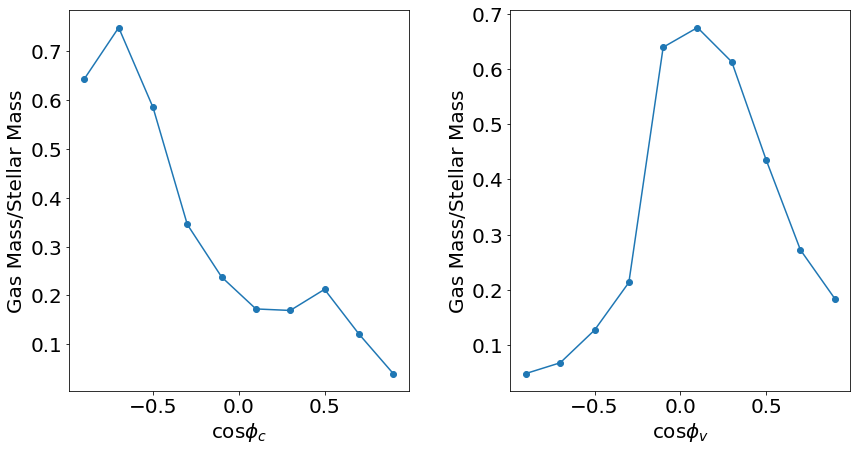

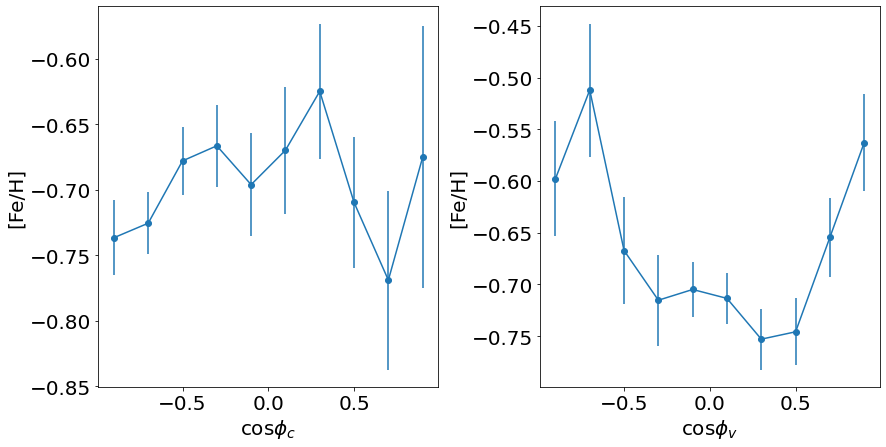

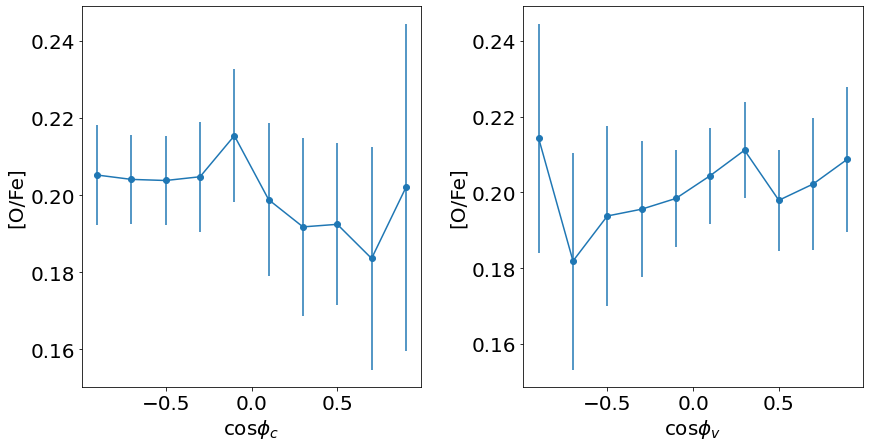

In [20]:
gal, cen = 4471, 4469

physD, Snap, mmr, firstsnap, Nturn, theID, theIDC = getperi(gal, cen)
cosV, cosC, GasMasses, GassAbundances, temporder_near, temporder_near2 = getAllLastP(theID, theIDC, Snap)

offST = sim['SnapNumber_{}/SubGroups/PartType4/Offsets'.format(Snap)][theID].astype('int')
stars = sim['SnapNumber_{}/PartType4/Masses'.format(Snap)][offST[0]:offST[1]]
SMass = np.sum(stars)

pl.figure(figsize=(14, 7))

pl.subplots_adjust(wspace=0.3)

sumC, binsC, zipC = sp.binned_statistic(cosC, GasMasses/SMass, statistic='sum', bins=10, range=(-1.,1.))
sumV, binsV, zipV = sp.binned_statistic(cosV, GasMasses/SMass, statistic='sum', bins=10, range=(-1.,1.))

x_x = .5*(binsV[:-1]+binsV[1:])

pl.subplot(1, 2, 1)

pl.plot(x_x, sumC, marker='o')

pl.xlabel('$\cos \phi_c$')
pl.ylabel('Gas Mass/Stellar Mass')

pl.subplot(1, 2, 2)

pl.errorbar(x_x, sumV, marker='o')

pl.xlabel('$\cos \phi_v$')
pl.ylabel('Gas Mass/Stellar Mass')

pl.figure(figsize=(14, 7))

pl.subplots_adjust(wspace=0.3)

inn = np.where((np.isnan(temporder_near)==False) & (np.isinf(temporder_near)==False))

cosC_ = cosC[inn]
cosV_ = cosV[inn]
temp = temporder_near[inn]

sumC, binsC, zipC = sp.binned_statistic(cosC_, temp, statistic='median', bins=10, range=(-1.,1.))
sumV, binsV, zipV = sp.binned_statistic(cosV_, temp, statistic='median', bins=10, range=(-1.,1.))

stdC, binsC, zipC = sp.binned_statistic(cosC_, temp, statistic='std', bins=10, range=(-1.,1.))
stdV, binsV, zipV = sp.binned_statistic(cosV_, temp, statistic='std', bins=10, range=(-1.,1.))

numbC, binsC, zipC = sp.binned_statistic(cosC_, temp, statistic='count', bins=10, range=(-1.,1.))
numbV, binsV, zipV = sp.binned_statistic(cosV_, temp, statistic='count', bins=10, range=(-1.,1.))

errC = stdC/np.sqrt(numbC) * np.sqrt(np.pi/2.)
errV = stdV/np.sqrt(numbV) * np.sqrt(np.pi/2.)

x_x = .5*(binsV[:-1]+binsV[1:])

pl.subplot(1, 2, 1)

pl.errorbar(x_x, sumC, yerr=errC, marker='o')

pl.xlabel('$\cos \phi_c$')
pl.ylabel('[Fe/H]')

pl.subplot(1, 2, 2)

pl.errorbar(x_x, sumV, yerr=errV, marker='o')

pl.xlabel('$\cos \phi_v$')
pl.ylabel('[Fe/H]')

pl.figure(figsize=(14, 7))

pl.subplots_adjust(wspace=0.3)

inn = np.where((np.isnan(temporder_near2)==False) & (np.isinf(temporder_near2)==False))

cosC_ = cosC[inn]
cosV_ = cosV[inn]
temp = temporder_near2[inn]

sumC, binsC, zipC = sp.binned_statistic(cosC_, temp, statistic='median', bins=10, range=(-1.,1.))
sumV, binsV, zipV = sp.binned_statistic(cosV_, temp, statistic='median', bins=10, range=(-1.,1.))

stdC, binsC, zipC = sp.binned_statistic(cosC_, temp, statistic='std', bins=10, range=(-1.,1.))
stdV, binsV, zipV = sp.binned_statistic(cosV_, temp, statistic='std', bins=10, range=(-1.,1.))

numbC, binsC, zipC = sp.binned_statistic(cosC_, temp, statistic='count', bins=10, range=(-1.,1.))
numbV, binsV, zipV = sp.binned_statistic(cosV_, temp, statistic='count', bins=10, range=(-1.,1.))

errC = stdC/np.sqrt(numbC) * np.sqrt(np.pi/2.)
errV = stdV/np.sqrt(numbV) * np.sqrt(np.pi/2.)

x_x = .5*(binsV[:-1]+binsV[1:])

pl.subplot(1, 2, 1)

pl.errorbar(x_x, sumC, yerr=errC, marker='o')

pl.xlabel('$\cos \phi_c$')
pl.ylabel('[O/Fe]')

pl.subplot(1, 2, 2)

pl.errorbar(x_x, sumV, yerr=errV, marker='o')

pl.xlabel('$\cos \phi_v$')
pl.ylabel('[O/Fe]')

/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:35: RuntimeWarning: divide by zero encountered in log10
/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:38: RuntimeWarning: invalid value encountered in true_divide


Text(0, 0.5, '[O/Fe]')

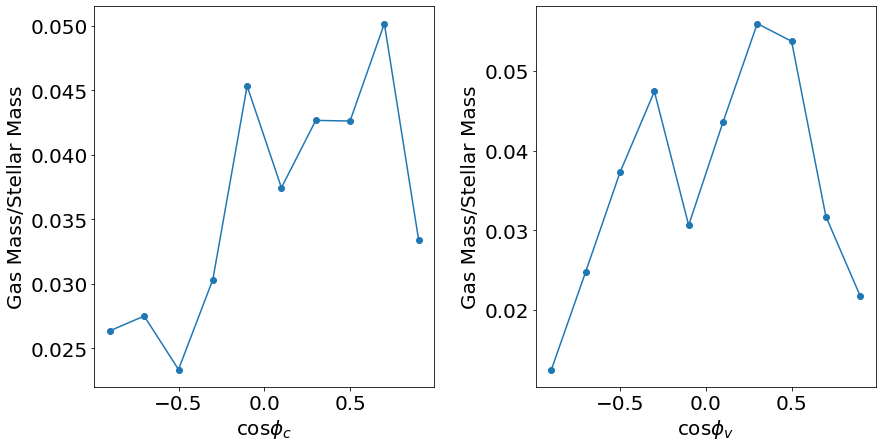

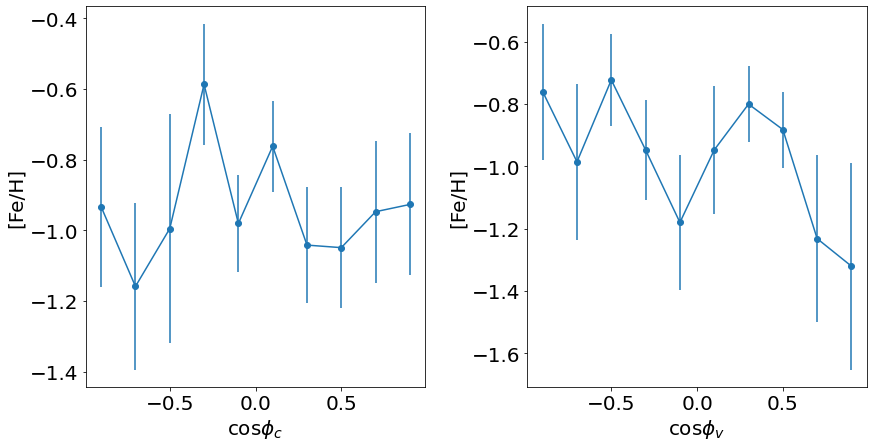

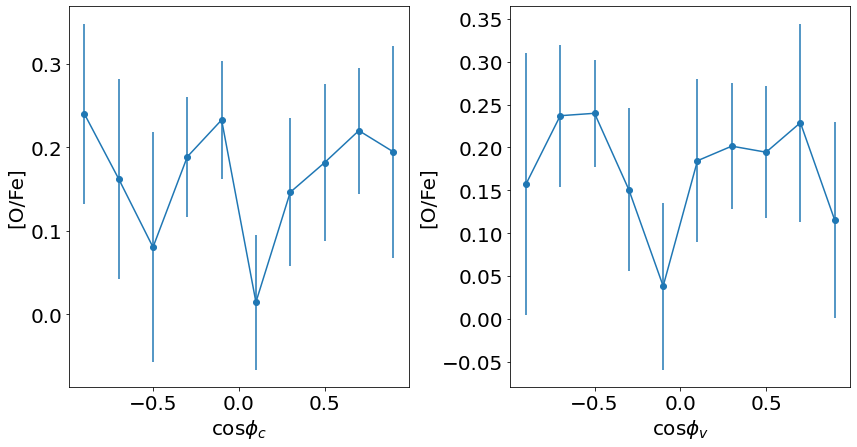

In [21]:
gal, cen = 4473, 4469

physD, Snap, mmr, firstsnap, Nturn, theID, theIDC = getperi(gal, cen)
cosV, cosC, GasMasses, GassAbundances, temporder_near, temporder_near2 = getAllLastP(theID, theIDC, Snap)

offST = sim['SnapNumber_{}/SubGroups/PartType4/Offsets'.format(Snap)][theID].astype('int')
stars = sim['SnapNumber_{}/PartType4/Masses'.format(Snap)][offST[0]:offST[1]]
SMass = np.sum(stars)

pl.figure(figsize=(14, 7))

pl.subplots_adjust(wspace=0.3)

sumC, binsC, zipC = sp.binned_statistic(cosC, GasMasses/SMass, statistic='sum', bins=10, range=(-1.,1.))
sumV, binsV, zipV = sp.binned_statistic(cosV, GasMasses/SMass, statistic='sum', bins=10, range=(-1.,1.))

x_x = .5*(binsV[:-1]+binsV[1:])

pl.subplot(1, 2, 1)

pl.plot(x_x, sumC, marker='o')

pl.xlabel('$\cos \phi_c$')
pl.ylabel('Gas Mass/Stellar Mass')

pl.subplot(1, 2, 2)

pl.errorbar(x_x, sumV, marker='o')

pl.xlabel('$\cos \phi_v$')
pl.ylabel('Gas Mass/Stellar Mass')

pl.figure(figsize=(14, 7))

pl.subplots_adjust(wspace=0.3)

inn = np.where((np.isnan(temporder_near)==False) & (np.isinf(temporder_near)==False))

cosC_ = cosC[inn]
cosV_ = cosV[inn]
temp = temporder_near[inn]

sumC, binsC, zipC = sp.binned_statistic(cosC_, temp, statistic='median', bins=10, range=(-1.,1.))
sumV, binsV, zipV = sp.binned_statistic(cosV_, temp, statistic='median', bins=10, range=(-1.,1.))

stdC, binsC, zipC = sp.binned_statistic(cosC_, temp, statistic='std', bins=10, range=(-1.,1.))
stdV, binsV, zipV = sp.binned_statistic(cosV_, temp, statistic='std', bins=10, range=(-1.,1.))

numbC, binsC, zipC = sp.binned_statistic(cosC_, temp, statistic='count', bins=10, range=(-1.,1.))
numbV, binsV, zipV = sp.binned_statistic(cosV_, temp, statistic='count', bins=10, range=(-1.,1.))

errC = stdC/np.sqrt(numbC) * np.sqrt(np.pi/2.)
errV = stdV/np.sqrt(numbV) * np.sqrt(np.pi/2.)

x_x = .5*(binsV[:-1]+binsV[1:])

pl.subplot(1, 2, 1)

pl.errorbar(x_x, sumC, yerr=errC, marker='o')

pl.xlabel('$\cos \phi_c$')
pl.ylabel('[Fe/H]')

pl.subplot(1, 2, 2)

pl.errorbar(x_x, sumV, yerr=errV, marker='o')

pl.xlabel('$\cos \phi_v$')
pl.ylabel('[Fe/H]')

pl.figure(figsize=(14, 7))

pl.subplots_adjust(wspace=0.3)

inn = np.where((np.isnan(temporder_near2)==False) & (np.isinf(temporder_near2)==False))

cosC_ = cosC[inn]
cosV_ = cosV[inn]
temp = temporder_near2[inn]

sumC, binsC, zipC = sp.binned_statistic(cosC_, temp, statistic='median', bins=10, range=(-1.,1.))
sumV, binsV, zipV = sp.binned_statistic(cosV_, temp, statistic='median', bins=10, range=(-1.,1.))

stdC, binsC, zipC = sp.binned_statistic(cosC_, temp, statistic='std', bins=10, range=(-1.,1.))
stdV, binsV, zipV = sp.binned_statistic(cosV_, temp, statistic='std', bins=10, range=(-1.,1.))

numbC, binsC, zipC = sp.binned_statistic(cosC_, temp, statistic='count', bins=10, range=(-1.,1.))
numbV, binsV, zipV = sp.binned_statistic(cosV_, temp, statistic='count', bins=10, range=(-1.,1.))

errC = stdC/np.sqrt(numbC) * np.sqrt(np.pi/2.)
errV = stdV/np.sqrt(numbV) * np.sqrt(np.pi/2.)

x_x = .5*(binsV[:-1]+binsV[1:])

pl.subplot(1, 2, 1)

pl.errorbar(x_x, sumC, yerr=errC, marker='o')

pl.xlabel('$\cos \phi_c$')
pl.ylabel('[O/Fe]')

pl.subplot(1, 2, 2)

pl.errorbar(x_x, sumV, yerr=errV, marker='o')

pl.xlabel('$\cos \phi_v$')
pl.ylabel('[O/Fe]')

/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:35: RuntimeWarning: divide by zero encountered in log10
/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:38: RuntimeWarning: invalid value encountered in true_divide


Text(0, 0.5, '[O/Fe]')

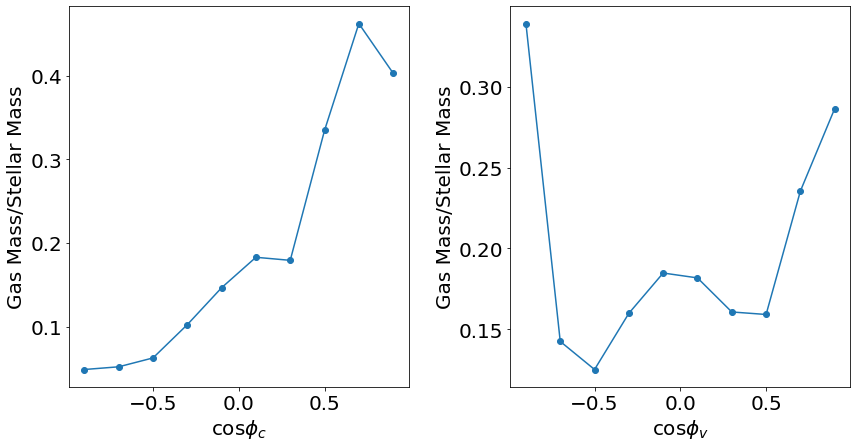

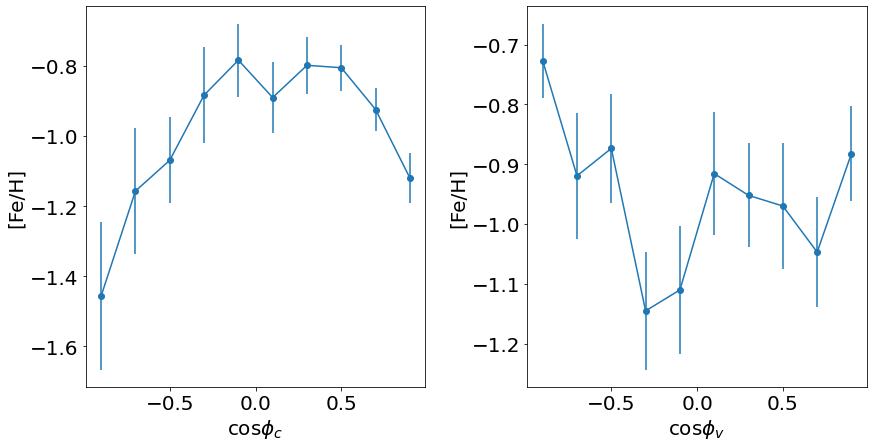

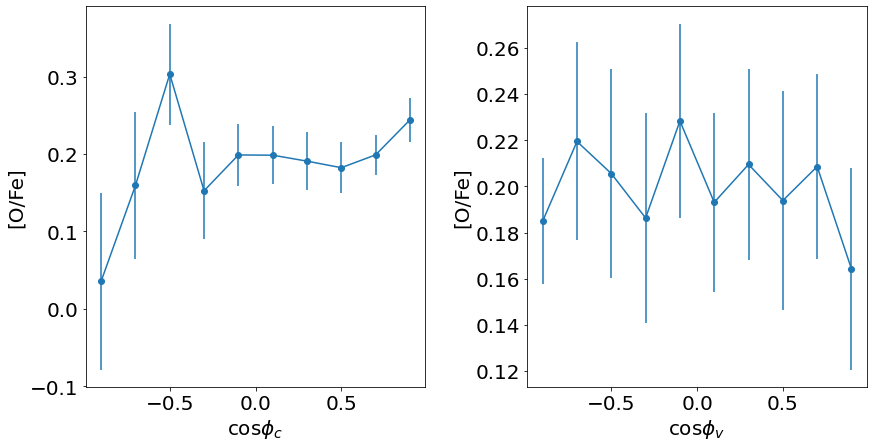

In [22]:
gal, cen = 4474, 4469

physD, Snap, mmr, firstsnap, Nturn, theID, theIDC = getperi(gal, cen)
cosV, cosC, GasMasses, GassAbundances, temporder_near, temporder_near2 = getAllLastP(theID, theIDC, Snap)

offST = sim['SnapNumber_{}/SubGroups/PartType4/Offsets'.format(Snap)][theID].astype('int')
stars = sim['SnapNumber_{}/PartType4/Masses'.format(Snap)][offST[0]:offST[1]]
SMass = np.sum(stars)

pl.figure(figsize=(14, 7))

pl.subplots_adjust(wspace=0.3)

sumC, binsC, zipC = sp.binned_statistic(cosC, GasMasses/SMass, statistic='sum', bins=10, range=(-1.,1.))
sumV, binsV, zipV = sp.binned_statistic(cosV, GasMasses/SMass, statistic='sum', bins=10, range=(-1.,1.))

x_x = .5*(binsV[:-1]+binsV[1:])

pl.subplot(1, 2, 1)

pl.plot(x_x, sumC, marker='o')

pl.xlabel('$\cos \phi_c$')
pl.ylabel('Gas Mass/Stellar Mass')

pl.subplot(1, 2, 2)

pl.errorbar(x_x, sumV, marker='o')

pl.xlabel('$\cos \phi_v$')
pl.ylabel('Gas Mass/Stellar Mass')

pl.figure(figsize=(14, 7))

pl.subplots_adjust(wspace=0.3)

inn = np.where((np.isnan(temporder_near)==False) & (np.isinf(temporder_near)==False))

cosC_ = cosC[inn]
cosV_ = cosV[inn]
temp = temporder_near[inn]

sumC, binsC, zipC = sp.binned_statistic(cosC_, temp, statistic='median', bins=10, range=(-1.,1.))
sumV, binsV, zipV = sp.binned_statistic(cosV_, temp, statistic='median', bins=10, range=(-1.,1.))

stdC, binsC, zipC = sp.binned_statistic(cosC_, temp, statistic='std', bins=10, range=(-1.,1.))
stdV, binsV, zipV = sp.binned_statistic(cosV_, temp, statistic='std', bins=10, range=(-1.,1.))

numbC, binsC, zipC = sp.binned_statistic(cosC_, temp, statistic='count', bins=10, range=(-1.,1.))
numbV, binsV, zipV = sp.binned_statistic(cosV_, temp, statistic='count', bins=10, range=(-1.,1.))

errC = stdC/np.sqrt(numbC) * np.sqrt(np.pi/2.)
errV = stdV/np.sqrt(numbV) * np.sqrt(np.pi/2.)

x_x = .5*(binsV[:-1]+binsV[1:])

pl.subplot(1, 2, 1)

pl.errorbar(x_x, sumC, yerr=errC, marker='o')

pl.xlabel('$\cos \phi_c$')
pl.ylabel('[Fe/H]')

pl.subplot(1, 2, 2)

pl.errorbar(x_x, sumV, yerr=errV, marker='o')

pl.xlabel('$\cos \phi_v$')
pl.ylabel('[Fe/H]')

pl.figure(figsize=(14, 7))

pl.subplots_adjust(wspace=0.3)

inn = np.where((np.isnan(temporder_near2)==False) & (np.isinf(temporder_near2)==False))

cosC_ = cosC[inn]
cosV_ = cosV[inn]
temp = temporder_near2[inn]

sumC, binsC, zipC = sp.binned_statistic(cosC_, temp, statistic='median', bins=10, range=(-1.,1.))
sumV, binsV, zipV = sp.binned_statistic(cosV_, temp, statistic='median', bins=10, range=(-1.,1.))

stdC, binsC, zipC = sp.binned_statistic(cosC_, temp, statistic='std', bins=10, range=(-1.,1.))
stdV, binsV, zipV = sp.binned_statistic(cosV_, temp, statistic='std', bins=10, range=(-1.,1.))

numbC, binsC, zipC = sp.binned_statistic(cosC_, temp, statistic='count', bins=10, range=(-1.,1.))
numbV, binsV, zipV = sp.binned_statistic(cosV_, temp, statistic='count', bins=10, range=(-1.,1.))

errC = stdC/np.sqrt(numbC) * np.sqrt(np.pi/2.)
errV = stdV/np.sqrt(numbV) * np.sqrt(np.pi/2.)

x_x = .5*(binsV[:-1]+binsV[1:])

pl.subplot(1, 2, 1)

pl.errorbar(x_x, sumC, yerr=errC, marker='o')

pl.xlabel('$\cos \phi_c$')
pl.ylabel('[O/Fe]')

pl.subplot(1, 2, 2)

pl.errorbar(x_x, sumV, yerr=errV, marker='o')

pl.xlabel('$\cos \phi_v$')
pl.ylabel('[O/Fe]')

/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:35: RuntimeWarning: divide by zero encountered in log10
/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:38: RuntimeWarning: invalid value encountered in true_divide


Text(0, 0.5, '[O/Fe]')

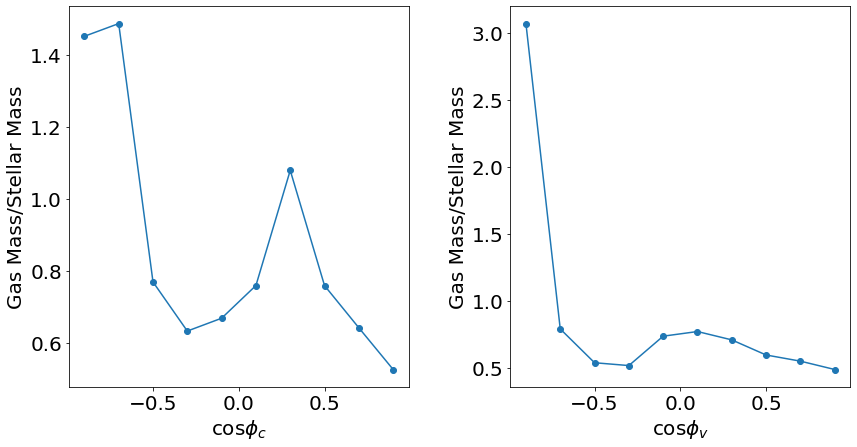

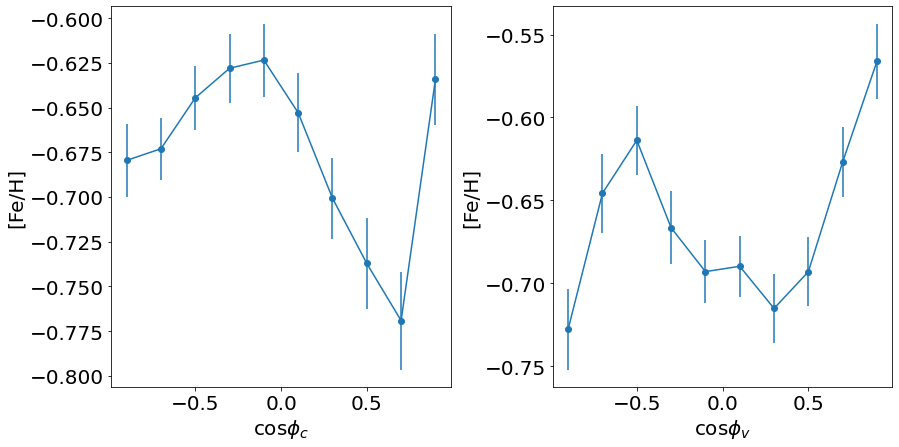

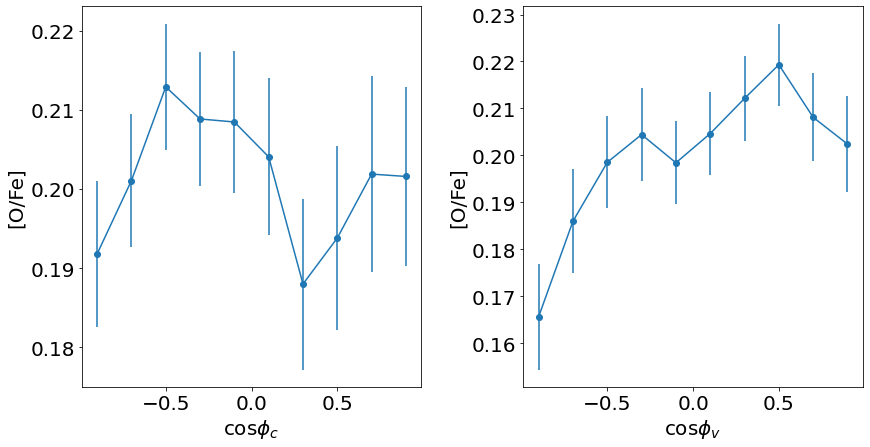

In [23]:
# ok, lets go with all
satlist = np.array([4338, 4339, 4341, 4343, 4470, 4471, 4473, 4474])
cenlist = np.array([4337, 4337, 4337, 4337, 4469, 4469, 4469, 4469])


CosC, CosV, GASMasses, TEMP, TEMP2, STMass = [], [], [], [], [], []

for gal, cen in zip(satlist, cenlist):
    physD, Snap, mmr, firstsnap, Nturn, theID, theIDC = getperi(gal, cen)
    cosV, cosC, GasMasses, GassAbundances, temporder_near, temporder_near2 = getAllLastP(theID, theIDC, Snap)

    offST = sim['SnapNumber_128/SubGroups/PartType4/Offsets'][gal].astype('int')
    stars = sim['SnapNumber_128/PartType4/Masses'][offST[0]:offST[1]]
    SMass = np.sum(stars)
    
    CosC.extend(list(cosC))
    CosV.extend(list(cosV))
    
    GASMasses.extend(list(GasMasses))
    STMass.extend([SMass]*cosC.size)
    TEMP.extend(list(temporder_near))
    TEMP2.extend(list(temporder_near2))

    
CosC, CosV, GASMasses, TEMP, TEMP2, STMass = np.array(CosC), np.array(CosV), np.array(GASMasses), np.array(TEMP), np.array(TEMP2), np.array(STMass)
    
pl.figure(figsize=(14, 7))

pl.subplots_adjust(wspace=0.3)

sumC, binsC, zipC = sp.binned_statistic(CosC, GASMasses/STMass, statistic='sum', bins=10, range=(-1.,1.))
sumV, binsV, zipV = sp.binned_statistic(CosV, GASMasses/STMass, statistic='sum', bins=10, range=(-1.,1.))

x_x = .5*(binsV[:-1]+binsV[1:])

pl.subplot(1, 2, 1)

pl.plot(x_x, sumC, marker='o')

pl.xlabel('$\cos \phi_c$')
pl.ylabel('Gas Mass/Stellar Mass')

pl.subplot(1, 2, 2)

pl.errorbar(x_x, sumV, marker='o')

pl.xlabel('$\cos \phi_v$')
pl.ylabel('Gas Mass/Stellar Mass')

pl.figure(figsize=(14, 7))

pl.subplots_adjust(wspace=0.3)

inn = np.where((np.isnan(TEMP)==False) & (np.isinf(TEMP)==False))

cosC_ = CosC[inn]
cosV_ = CosV[inn]
temp = TEMP[inn]

sumC, binsC, zipC = sp.binned_statistic(cosC_, temp, statistic='median', bins=10, range=(-1.,1.))
sumV, binsV, zipV = sp.binned_statistic(cosV_, temp, statistic='median', bins=10, range=(-1.,1.))

stdC, binsC, zipC = sp.binned_statistic(cosC_, temp, statistic='std', bins=10, range=(-1.,1.))
stdV, binsV, zipV = sp.binned_statistic(cosV_, temp, statistic='std', bins=10, range=(-1.,1.))

numbC, binsC, zipC = sp.binned_statistic(cosC_, temp, statistic='count', bins=10, range=(-1.,1.))
numbV, binsV, zipV = sp.binned_statistic(cosV_, temp, statistic='count', bins=10, range=(-1.,1.))

errC = stdC/np.sqrt(numbC) * np.sqrt(np.pi/2.)
errV = stdV/np.sqrt(numbV) * np.sqrt(np.pi/2.)

x_x = .5*(binsV[:-1]+binsV[1:])

pl.subplot(1, 2, 1)

pl.errorbar(x_x, sumC, yerr=errC, marker='o')

pl.xlabel('$\cos \phi_c$')
pl.ylabel('[Fe/H]')

pl.subplot(1, 2, 2)

pl.errorbar(x_x, sumV, yerr=errV, marker='o')

pl.xlabel('$\cos \phi_v$')
pl.ylabel('[Fe/H]')

pl.figure(figsize=(14, 7))

pl.subplots_adjust(wspace=0.3)

inn = np.where((np.isnan(TEMP2)==False) & (np.isinf(TEMP2)==False))

cosC_ = CosC[inn]
cosV_ = CosV[inn]
temp = TEMP2[inn]

sumC, binsC, zipC = sp.binned_statistic(cosC_, temp, statistic='median', bins=10, range=(-1.,1.))
sumV, binsV, zipV = sp.binned_statistic(cosV_, temp, statistic='median', bins=10, range=(-1.,1.))

stdC, binsC, zipC = sp.binned_statistic(cosC_, temp, statistic='std', bins=10, range=(-1.,1.))
stdV, binsV, zipV = sp.binned_statistic(cosV_, temp, statistic='std', bins=10, range=(-1.,1.))

numbC, binsC, zipC = sp.binned_statistic(cosC_, temp, statistic='count', bins=10, range=(-1.,1.))
numbV, binsV, zipV = sp.binned_statistic(cosV_, temp, statistic='count', bins=10, range=(-1.,1.))

errC = stdC/np.sqrt(numbC) * np.sqrt(np.pi/2.)
errV = stdV/np.sqrt(numbV) * np.sqrt(np.pi/2.)

x_x = .5*(binsV[:-1]+binsV[1:])

pl.subplot(1, 2, 1)

pl.errorbar(x_x, sumC, yerr=errC, marker='o')

pl.xlabel('$\cos \phi_c$')
pl.ylabel('[O/Fe]')

pl.subplot(1, 2, 2)

pl.errorbar(x_x, sumV, yerr=errV, marker='o')

pl.xlabel('$\cos \phi_v$')
pl.ylabel('[O/Fe]')

In [24]:
# ok, lets do a new version of the thing that measures the thing by snapshot, and return mass and stuff
def getAllLastP_int(fofID, centralID, TheSnap):
    """
    get position, masses and abundances of all particles that in past snapshot belong to a given subhalo,
    and a z=0 are located at athe maximum distance of 600 kpc to the subhalo,
    rotated by the velocity and the vector to the centre.
    """
    uniqueID = int(TheSnap*1e6+fofID)
    stree = networkx.dfs_tree(trees, str(uniqueID))
#     mtree = get_main_branch_unique_ids(stree, str(uniqueID))
    mtree = get_main_branch_backwards(stree, str(uniqueID))
    
    TdayTotalIDs = sim['SnapNumber_{}/PartType0/ParticleIDs'.format(TheSnap)][()]
    
    #firts find all the particleIDs that once belong to the subgroup
    Idlist = []
    templist = []
    templist2 = []

    
    for mm in mtree[1:]: # ignore the first one
        snap, idd = split_unique_id(int(mm))
        tempOff = sim['SnapNumber_{}/SubGroups/PartType0/Offsets'.format(snap)][idd].astype('int')
        if tempOff[0]>= 0 and tempOff[1]>=0:
            tempIds = sim['SnapNumber_{}/PartType0/ParticleIDs'.format(snap)][tempOff[0]:tempOff[1]]
#             # and the temperature
#             IE = sim['SnapNumber_{}/PartType0/InternalEnergy'.format(snap)][tempOff[0]:tempOff[1]]
#             Mass = sim['SnapNumber_{}/PartType0/Masses'.format(snap)][tempOff[0]:tempOff[1]]
#             Abund = sim['SnapNumber_{}/PartType0/Abundances'.format(snap)][tempOff[0]:tempOff[1]]
#             ne1 = sim['SnapNumber_{}/PartType0/ElectronAbundance'.format(snap)][tempOff[0]:tempOff[1]]
#             val2 = tempFromMass(Mass, Abund, IE, ne1)
#             templist2.extend(list(val2))
            # and the metallicity
    
    
            rop = sim['SnapNumber_{}/SubGroups/OpticalRadius'.format(snap)][idd]
            posGal = sim['SnapNumber_{}/SubGroups/SubGroupPos'.format(snap)][idd]
            posPart = sim['SnapNumber_{}/PartType0/Coordinates'.format(snap)][tempOff[0]:tempOff[1]]
                
            xx, yy, zz = posPart[:,0] - posGal[0], posPart[:,1] - posGal[1], posPart[:,2] - posGal[2]
                
            rr =np.sqrt(xx**2+yy**2+zz**2.)
                
            ik = np.where(rr<rop)
                
            AbundatTime = sim['SnapNumber_{}/PartType0/Abundances'.format(snap)][tempOff[0]:tempOff[1]]
            val = np.log10((AbundatTime[:,4]/FeMass)/(AbundatTime[:,6]/HMass)) - NfeNhe_sun
#             val = (AbundatTime[:,4]/FeMass)/(AbundatTime[:,6]/HMass)
            templist.extend(list(val[ik]))
            val2 = np.log10((AbundatTime[:,3]/OMass)/(AbundatTime[:,4]/FeMass)) - NoNfe_sun
            templist2.extend(list(val2[ik]))
            #zz = sim['SnapNumber_{}/Header/Redshift'.format(snap)][()]
            #templist.extend([zz]*tempIds.size)
            Idlist.extend(list(tempIds[ik]))

    Idlist = np.array(Idlist)
    templist = np.array(templist)
    templist2 = np.array(templist2)
    
    Idlist, Idunique = np.unique(Idlist, return_index=True) # remove duplicates
    templist = templist[Idunique]
    templist2 = templist2[Idunique]
    
    TdayOff = sim['SnapNumber_{}/SubGroups/PartType0/Offsets'.format(TheSnap)][fofID].astype('int')
    
    IndexToday = np.in1d(TdayTotalIDs, Idlist)
    IndexToday_ = np.where(IndexToday)[0]
    
    # lets remove the ones that are not part of the group today.
    TdayIDs = sim['SnapNumber_{}/PartType0/ParticleIDs'.format(TheSnap)][TdayOff[0]:TdayOff[1]]

    IndexNot = np.in1d(Idlist, TdayIDs)
    IdNot = Idlist[np.where(IndexNot==False)[0]]

    IndexT = np.in1d(TdayTotalIDs, IdNot)
    IndexT_ = np.where(IndexT)[0]
    
    # and temperature
    SurvIds_ = TdayTotalIDs[IndexT_]
    iidex = np.in1d(Idlist, SurvIds_)
    iidex_ = np.where(iidex)[0]
    templist_, Idlist_ = templist[iidex_], Idlist[iidex_]
    templist2_ = templist2[iidex_]

    is1 = np.argsort(SurvIds_) # the target
    is2 = np.argsort(Idlist_)

    temporder = np.zeros(IndexT_.size)
    temporder[is1] = templist_[is2]
    
    temporder2 = np.zeros(IndexT_.size)
    temporder2[is1] = templist2_[is2]
    
    #now lets cut at  a certain distance
    #distance = 600 # distance in ckpc
    distance = 200 
    
    posGal = sim['SnapNumber_{}/SubGroups/SubGroupPos'.format(TheSnap)][fofID]
    posCen = sim['SnapNumber_{}/SubGroups/SubGroupPos'.format(TheSnap)][centralID]

    LostCoord = sim['SnapNumber_{}/PartType0/Coordinates'.format(TheSnap)][IndexT_]
    
    dx, dy, dz = LostCoord[:,0]-posGal[0], LostCoord[:,1]-posGal[1], LostCoord[:,2]-posGal[2]
    distToC = np.sqrt(dx**2+dy**2+dz**2)

    icut = np.where(distToC<distance)[0]
    IndexT_near = IndexT_[icut] # this is the final list of particles ids
    temporder_near = temporder[icut]
    temporder_near2 = temporder2[icut]
    
    LostNow = sim['SnapNumber_{}/PartType0/SubGroupNumber'.format(TheSnap)][IndexT_near]
    
    icut2 = np.where(LostNow==-1)[0] # idk, for now no
    IndexT_near = IndexT_near[icut2]
    temporder_near = temporder_near[icut2]
    temporder_near2 = temporder_near2[icut2]
    
    # ok, lest see velocity and stuff
    velCen = sim['SnapNumber_{}/SubGroups/SubGroupVel'.format(TheSnap)][centralID]
    velSat = sim['SnapNumber_{}/SubGroups/SubGroupVel'.format(TheSnap)][fofID]

    velRep = velSat - velCen
    
    GasMasses = sim['SnapNumber_{}/PartType0/Masses'.format(TheSnap)][IndexT_near]
    GassAbundances = sim['SnapNumber_{}/PartType0/Abundances'.format(TheSnap)][IndexT_near]
    
    NearCoord = sim['SnapNumber_{}/PartType0/Coordinates'.format(TheSnap)][IndexT_near]

#     IE0 = sim['SnapNumber_128/PartType0/InternalEnergy'][IndexT_near]
#     ne10 = sim['SnapNumber_128/PartType0/ElectronAbundance'][IndexT_near]
#     t0 = tempFromMass(GasMasses, GassAbundances, IE0, ne10)
    
#     temporder_near = temporder_near - t0
#     temporder_near = t0 # not so subtle replacement
    # first lets re-define coordinates in a galactocentric scheme.
    X, Y, Z = NearCoord[:,0] - posGal[0], NearCoord[:,1] - posGal[1], NearCoord[:,2] - posGal[2]
    xC, yC, zC = posCen[0] - posGal[0], posCen[1] - posGal[1], posCen[2] - posGal[2] # the direction of the centre from the galaxy
    
    # now define normalized vectors, for velocity and centre directions
    velX, velY, velZ = velRep[0], velRep[1], velRep[2]
    Vel = np.sqrt(velX**2 + velY**2 + velZ**2)
    Cen = np.sqrt(xC**2 + yC**2 + zC**2)

    velx, vely, velz = velX/Vel, velY/Vel, velZ/Vel
    xc, yc, zc = xC/Cen, yC/Cen, zC/Cen
    
    # Then, the rotations matrix are, for velocity
    faV = (1-velx)/(vely**2 + velz**2)
    VV = np.array([[0, vely, velz], [-vely, 0, 0], [-velz, 0, 0]])
    VV2 = np.matmul(VV, VV)

    RV = I + VV + VV2*faV
    
    # and for the direction to the centre
    faC = (1-xc)/(yc**2+zc**2)
    CC = np.array([[0, yc, zc], [-yc, 0, 0], [-zc, 0, 0]])
    CC2 = np.matmul(CC, CC)

    RC = I + CC + CC2*faC
    
    # lets calculate the rotated coordinates
    xRv, yRv, zRv = [], [], []
    xRc, yRc, zRc = [], [], []

    for x, y, z in zip(X, Y, Z):
        dV = np.matmul(RV, np.array([x, y, z]))
        dC = np.matmul(RC, np.array([x, y, z]))
    
        xRv.append(dV[0])
        yRv.append(dV[1])
        zRv.append(dV[2])
    
        xRc.append(dC[0])
        yRc.append(dC[1])
        zRc.append(dC[2])
    
    xRv, yRv, zRv = np.array(xRv), np.array(yRv), np.array(zRv)
    xRc, yRc, zRc = np.array(xRc), np.array(yRc), np.array(zRc)
    
    # now, I only need one number, the cos stuff
    cosC = xRc/np.sqrt(xRc**2.+yRc**2.+zRc**2.)
    cosV = xRv/np.sqrt(xRv**2.+yRv**2.+zRv**2.)
    
    # and return the 2 sets of rotated positions, masses and abundances
    return cosV, cosC, GasMasses, GassAbundances, temporder_near, temporder_near2

/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:47: RuntimeWarning: divide by zero encountered in log10
/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:50: RuntimeWarning: invalid value encountered in true_divide
/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:44: RuntimeWarning: invalid value encountered in less


Text(0, 0.5, '[O/Fe]')

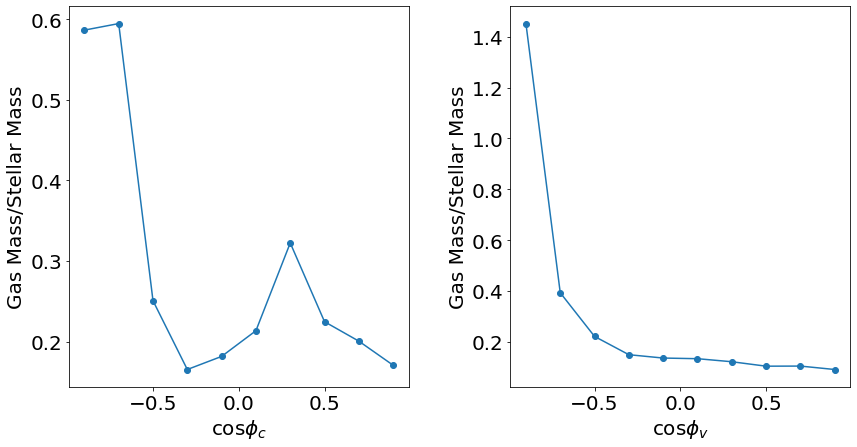

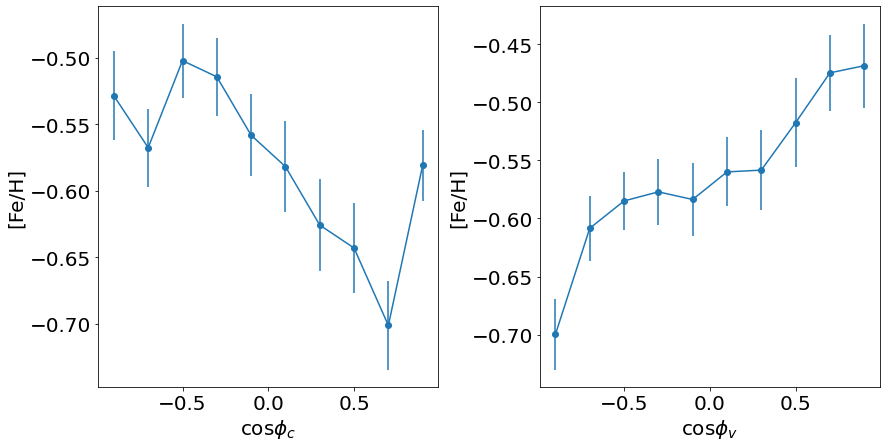

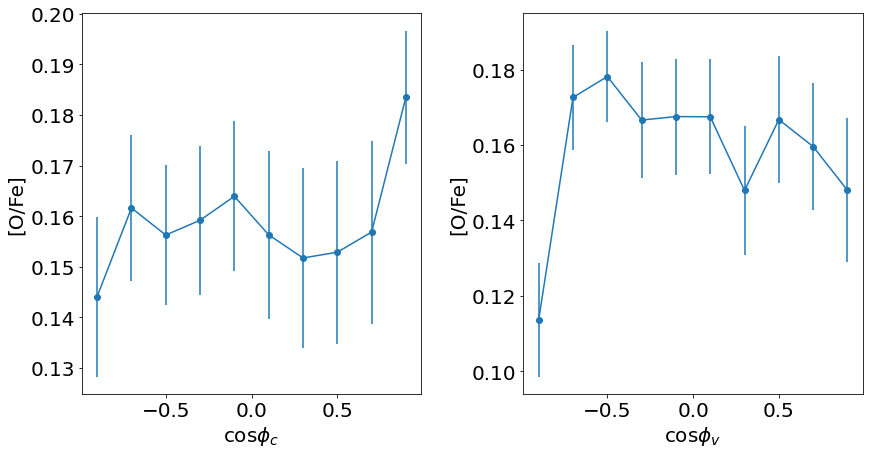

In [25]:
# ok, lets go with all
satlist = np.array([4338, 4339, 4341, 4343, 4470, 4471, 4473, 4474])
cenlist = np.array([4337, 4337, 4337, 4337, 4469, 4469, 4469, 4469])


CosC, CosV, GASMasses, TEMP, TEMP2, STMass = [], [], [], [], [], []

for gal, cen in zip(satlist, cenlist):
    physD, Snap, mmr, firstsnap, Nturn, theID, theIDC = getperi(gal, cen)
    cosV, cosC, GasMasses, GassAbundances, temporder_near, temporder_near2 = getAllLastP_int(theID, theIDC, Snap)

    offST = sim['SnapNumber_128/SubGroups/PartType4/Offsets'][gal].astype('int')
    stars = sim['SnapNumber_128/PartType4/Masses'][offST[0]:offST[1]]
    SMass = np.sum(stars)
    
    CosC.extend(list(cosC))
    CosV.extend(list(cosV))
    
    GASMasses.extend(list(GasMasses))
    STMass.extend([SMass]*cosC.size)
    TEMP.extend(list(temporder_near))
    TEMP2.extend(list(temporder_near2))

    
CosC, CosV, GASMasses, TEMP, TEMP2, STMass = np.array(CosC), np.array(CosV), np.array(GASMasses), np.array(TEMP), np.array(TEMP2), np.array(STMass)
    
pl.figure(figsize=(14, 7))

pl.subplots_adjust(wspace=0.3)

sumC, binsC, zipC = sp.binned_statistic(CosC, GASMasses/STMass, statistic='sum', bins=10, range=(-1.,1.))
sumV, binsV, zipV = sp.binned_statistic(CosV, GASMasses/STMass, statistic='sum', bins=10, range=(-1.,1.))

x_x = .5*(binsV[:-1]+binsV[1:])

pl.subplot(1, 2, 1)

pl.plot(x_x, sumC, marker='o')

pl.xlabel('$\cos \phi_c$')
pl.ylabel('Gas Mass/Stellar Mass')

pl.subplot(1, 2, 2)

pl.errorbar(x_x, sumV, marker='o')

pl.xlabel('$\cos \phi_v$')
pl.ylabel('Gas Mass/Stellar Mass')

pl.figure(figsize=(14, 7))

pl.subplots_adjust(wspace=0.3)

inn = np.where((np.isnan(TEMP)==False) & (np.isinf(TEMP)==False))

cosC_ = CosC[inn]
cosV_ = CosV[inn]
temp = TEMP[inn]

sumC, binsC, zipC = sp.binned_statistic(cosC_, temp, statistic='median', bins=10, range=(-1.,1.))
sumV, binsV, zipV = sp.binned_statistic(cosV_, temp, statistic='median', bins=10, range=(-1.,1.))

stdC, binsC, zipC = sp.binned_statistic(cosC_, temp, statistic='std', bins=10, range=(-1.,1.))
stdV, binsV, zipV = sp.binned_statistic(cosV_, temp, statistic='std', bins=10, range=(-1.,1.))

numbC, binsC, zipC = sp.binned_statistic(cosC_, temp, statistic='count', bins=10, range=(-1.,1.))
numbV, binsV, zipV = sp.binned_statistic(cosV_, temp, statistic='count', bins=10, range=(-1.,1.))

errC = stdC/np.sqrt(numbC) * np.sqrt(np.pi/2.)
errV = stdV/np.sqrt(numbV) * np.sqrt(np.pi/2.)

x_x = .5*(binsV[:-1]+binsV[1:])

pl.subplot(1, 2, 1)

pl.errorbar(x_x, sumC, yerr=errC, marker='o')

pl.xlabel('$\cos \phi_c$')
pl.ylabel('[Fe/H]')

pl.subplot(1, 2, 2)

pl.errorbar(x_x, sumV, yerr=errV, marker='o')

pl.xlabel('$\cos \phi_v$')
pl.ylabel('[Fe/H]')

pl.figure(figsize=(14, 7))

pl.subplots_adjust(wspace=0.3)

inn = np.where((np.isnan(TEMP2)==False) & (np.isinf(TEMP2)==False))

cosC_ = CosC[inn]
cosV_ = CosV[inn]
temp = TEMP2[inn]

sumC, binsC, zipC = sp.binned_statistic(cosC_, temp, statistic='median', bins=10, range=(-1.,1.))
sumV, binsV, zipV = sp.binned_statistic(cosV_, temp, statistic='median', bins=10, range=(-1.,1.))

stdC, binsC, zipC = sp.binned_statistic(cosC_, temp, statistic='std', bins=10, range=(-1.,1.))
stdV, binsV, zipV = sp.binned_statistic(cosV_, temp, statistic='std', bins=10, range=(-1.,1.))

numbC, binsC, zipC = sp.binned_statistic(cosC_, temp, statistic='count', bins=10, range=(-1.,1.))
numbV, binsV, zipV = sp.binned_statistic(cosV_, temp, statistic='count', bins=10, range=(-1.,1.))

errC = stdC/np.sqrt(numbC) * np.sqrt(np.pi/2.)
errV = stdV/np.sqrt(numbV) * np.sqrt(np.pi/2.)

x_x = .5*(binsV[:-1]+binsV[1:])

pl.subplot(1, 2, 1)

pl.errorbar(x_x, sumC, yerr=errC, marker='o')

pl.xlabel('$\cos \phi_c$')
pl.ylabel('[O/Fe]')

pl.subplot(1, 2, 2)

pl.errorbar(x_x, sumV, yerr=errV, marker='o')

pl.xlabel('$\cos \phi_v$')
pl.ylabel('[O/Fe]')

/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:35: RuntimeWarning: divide by zero encountered in log10
/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:38: RuntimeWarning: invalid value encountered in true_divide


Text(0, 0.5, '[Fe/H]')

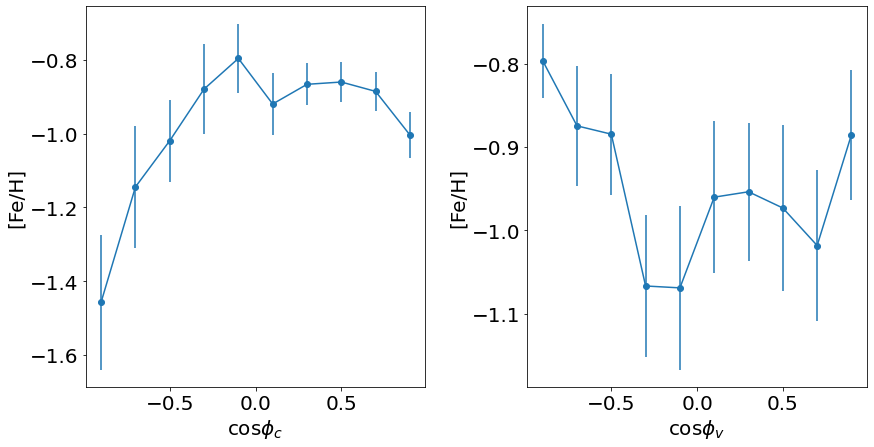

In [27]:
# ok, lets go with the pointing towards
satlist = np.array([4338, 4341, 4474])
cenlist = np.array([4337, 4337, 4469])

CosC, CosV, GASMasses, TEMP, TEMP2, STMass = [], [], [], [], [], []

for gal, cen in zip(satlist, cenlist):
    physD, Snap, mmr, firstsnap, Nturn, theID, theIDC = getperi(gal, cen)
    cosV, cosC, GasMasses, GassAbundances, temporder_near, temporder_near2 = getAllLastP(theID, theIDC, Snap)

    offST = sim['SnapNumber_128/SubGroups/PartType4/Offsets'][gal].astype('int')
    stars = sim['SnapNumber_128/PartType4/Masses'][offST[0]:offST[1]]
    SMass = np.sum(stars)
    
    CosC.extend(list(cosC))
    CosV.extend(list(cosV))
    
    GASMasses.extend(list(GasMasses))
    STMass.extend([SMass]*cosC.size)
    TEMP.extend(list(temporder_near))
    TEMP2.extend(list(temporder_near2))

    
CosC, CosV, GASMasses, TEMP, TEMP2, STMass = np.array(CosC), np.array(CosV), np.array(GASMasses), np.array(TEMP), np.array(TEMP2), np.array(STMass)
    
# pl.figure(figsize=(14, 7))

# pl.subplots_adjust(wspace=0.3)

# sumC, binsC, zipC = sp.binned_statistic(CosC, GASMasses/STMass, statistic='sum', bins=10, range=(-1.,1.))
# sumV, binsV, zipV = sp.binned_statistic(CosV, GASMasses/STMass, statistic='sum', bins=10, range=(-1.,1.))

# x_x = .5*(binsV[:-1]+binsV[1:])

# pl.subplot(1, 2, 1)

# pl.plot(x_x, sumC, marker='o')

# pl.xlabel('$\cos \phi_c$')
# pl.ylabel('Gas Mass/Stellar Mass')

# pl.subplot(1, 2, 2)

# pl.errorbar(x_x, sumV, marker='o')

# pl.xlabel('$\cos \phi_v$')
# pl.ylabel('Gas Mass/Stellar Mass')

pl.figure(figsize=(14, 7))

pl.subplots_adjust(wspace=0.3)

inn = np.where((np.isnan(TEMP)==False) & (np.isinf(TEMP)==False))

cosC_ = CosC[inn]
cosV_ = CosV[inn]
temp = TEMP[inn]

sumC, binsC, zipC = sp.binned_statistic(cosC_, temp, statistic='median', bins=10, range=(-1.,1.))
sumV, binsV, zipV = sp.binned_statistic(cosV_, temp, statistic='median', bins=10, range=(-1.,1.))

stdC, binsC, zipC = sp.binned_statistic(cosC_, temp, statistic='std', bins=10, range=(-1.,1.))
stdV, binsV, zipV = sp.binned_statistic(cosV_, temp, statistic='std', bins=10, range=(-1.,1.))

numbC, binsC, zipC = sp.binned_statistic(cosC_, temp, statistic='count', bins=10, range=(-1.,1.))
numbV, binsV, zipV = sp.binned_statistic(cosV_, temp, statistic='count', bins=10, range=(-1.,1.))

errC = stdC/np.sqrt(numbC) * np.sqrt(np.pi/2.)
errV = stdV/np.sqrt(numbV) * np.sqrt(np.pi/2.)

x_x = .5*(binsV[:-1]+binsV[1:])

pl.subplot(1, 2, 1)

pl.errorbar(x_x, sumC, yerr=errC, marker='o')

pl.xlabel('$\cos \phi_c$')
pl.ylabel('[Fe/H]')

pl.subplot(1, 2, 2)

pl.errorbar(x_x, sumV, yerr=errV, marker='o')

pl.xlabel('$\cos \phi_v$')
pl.ylabel('[Fe/H]')

# pl.figure(figsize=(14, 7))

# pl.subplots_adjust(wspace=0.3)

# inn = np.where((np.isnan(TEMP2)==False) & (np.isinf(TEMP2)==False))

# cosC_ = CosC[inn]
# cosV_ = CosV[inn]
# temp = TEMP2[inn]

# sumC, binsC, zipC = sp.binned_statistic(cosC_, temp, statistic='median', bins=10, range=(-1.,1.))
# sumV, binsV, zipV = sp.binned_statistic(cosV_, temp, statistic='median', bins=10, range=(-1.,1.))

# stdC, binsC, zipC = sp.binned_statistic(cosC_, temp, statistic='std', bins=10, range=(-1.,1.))
# stdV, binsV, zipV = sp.binned_statistic(cosV_, temp, statistic='std', bins=10, range=(-1.,1.))

# numbC, binsC, zipC = sp.binned_statistic(cosC_, temp, statistic='count', bins=10, range=(-1.,1.))
# numbV, binsV, zipV = sp.binned_statistic(cosV_, temp, statistic='count', bins=10, range=(-1.,1.))

# errC = stdC/np.sqrt(numbC) * np.sqrt(np.pi/2.)
# errV = stdV/np.sqrt(numbV) * np.sqrt(np.pi/2.)

# x_x = .5*(binsV[:-1]+binsV[1:])

# pl.subplot(1, 2, 1)

# pl.errorbar(x_x, sumC, yerr=errC, marker='o')

# pl.xlabel('$\cos \phi_c$')
# pl.ylabel('[O/Fe]')

# pl.subplot(1, 2, 2)

# pl.errorbar(x_x, sumV, yerr=errV, marker='o')

# pl.xlabel('$\cos \phi_v$')
# pl.ylabel('[O/Fe]')

/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:35: RuntimeWarning: divide by zero encountered in log10
/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:38: RuntimeWarning: invalid value encountered in true_divide


Text(0, 0.5, '[Fe/H]')

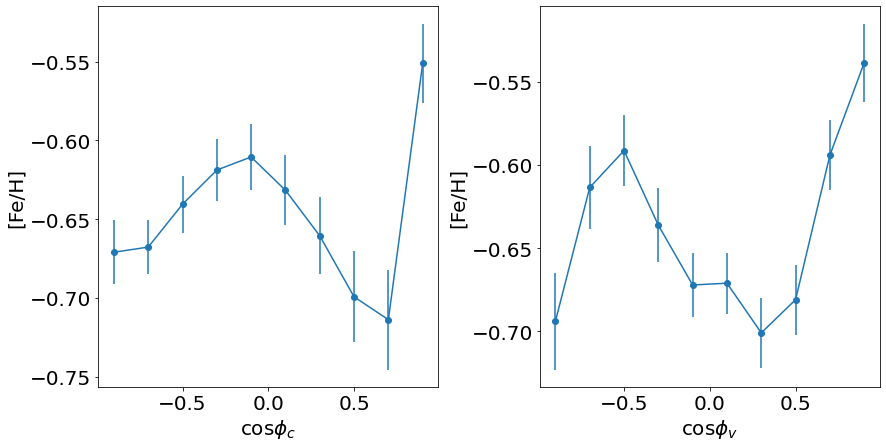

In [28]:
# ok, lets go with the pointing towards
satlist = np.array([4339, 4343, 4470, 4471, 4473])
cenlist = np.array([4337, 4337, 4469, 4469, 4469])


CosC, CosV, GASMasses, TEMP, TEMP2, STMass = [], [], [], [], [], []

for gal, cen in zip(satlist, cenlist):
    physD, Snap, mmr, firstsnap, Nturn, theID, theIDC = getperi(gal, cen)
    cosV, cosC, GasMasses, GassAbundances, temporder_near, temporder_near2 = getAllLastP(theID, theIDC, Snap)

    offST = sim['SnapNumber_128/SubGroups/PartType4/Offsets'][gal].astype('int')
    stars = sim['SnapNumber_128/PartType4/Masses'][offST[0]:offST[1]]
    SMass = np.sum(stars)
    
    CosC.extend(list(cosC))
    CosV.extend(list(cosV))
    
    GASMasses.extend(list(GasMasses))
    STMass.extend([SMass]*cosC.size)
    TEMP.extend(list(temporder_near))
    TEMP2.extend(list(temporder_near2))

    
CosC, CosV, GASMasses, TEMP, TEMP2, STMass = np.array(CosC), np.array(CosV), np.array(GASMasses), np.array(TEMP), np.array(TEMP2), np.array(STMass)
    
# pl.figure(figsize=(14, 7))

# pl.subplots_adjust(wspace=0.3)

# sumC, binsC, zipC = sp.binned_statistic(CosC, GASMasses/STMass, statistic='sum', bins=10, range=(-1.,1.))
# sumV, binsV, zipV = sp.binned_statistic(CosV, GASMasses/STMass, statistic='sum', bins=10, range=(-1.,1.))

# x_x = .5*(binsV[:-1]+binsV[1:])

# pl.subplot(1, 2, 1)

# pl.plot(x_x, sumC, marker='o')

# pl.xlabel('$\cos \phi_c$')
# pl.ylabel('Gas Mass/Stellar Mass')

# pl.subplot(1, 2, 2)

# pl.errorbar(x_x, sumV, marker='o')

# pl.xlabel('$\cos \phi_v$')
# pl.ylabel('Gas Mass/Stellar Mass')

pl.figure(figsize=(14, 7))

pl.subplots_adjust(wspace=0.3)

inn = np.where((np.isnan(TEMP)==False) & (np.isinf(TEMP)==False))

cosC_ = CosC[inn]
cosV_ = CosV[inn]
temp = TEMP[inn]

sumC, binsC, zipC = sp.binned_statistic(cosC_, temp, statistic='median', bins=10, range=(-1.,1.))
sumV, binsV, zipV = sp.binned_statistic(cosV_, temp, statistic='median', bins=10, range=(-1.,1.))

stdC, binsC, zipC = sp.binned_statistic(cosC_, temp, statistic='std', bins=10, range=(-1.,1.))
stdV, binsV, zipV = sp.binned_statistic(cosV_, temp, statistic='std', bins=10, range=(-1.,1.))

numbC, binsC, zipC = sp.binned_statistic(cosC_, temp, statistic='count', bins=10, range=(-1.,1.))
numbV, binsV, zipV = sp.binned_statistic(cosV_, temp, statistic='count', bins=10, range=(-1.,1.))

errC = stdC/np.sqrt(numbC) * np.sqrt(np.pi/2.)
errV = stdV/np.sqrt(numbV) * np.sqrt(np.pi/2.)

x_x = .5*(binsV[:-1]+binsV[1:])

pl.subplot(1, 2, 1)

pl.errorbar(x_x, sumC, yerr=errC, marker='o')

pl.xlabel('$\cos \phi_c$')
pl.ylabel('[Fe/H]')

pl.subplot(1, 2, 2)

pl.errorbar(x_x, sumV, yerr=errV, marker='o')

pl.xlabel('$\cos \phi_v$')
pl.ylabel('[Fe/H]')

# pl.figure(figsize=(14, 7))

# pl.subplots_adjust(wspace=0.3)

# inn = np.where((np.isnan(TEMP2)==False) & (np.isinf(TEMP2)==False))

# cosC_ = CosC[inn]
# cosV_ = CosV[inn]
# temp = TEMP2[inn]

# sumC, binsC, zipC = sp.binned_statistic(cosC_, temp, statistic='median', bins=10, range=(-1.,1.))
# sumV, binsV, zipV = sp.binned_statistic(cosV_, temp, statistic='median', bins=10, range=(-1.,1.))

# stdC, binsC, zipC = sp.binned_statistic(cosC_, temp, statistic='std', bins=10, range=(-1.,1.))
# stdV, binsV, zipV = sp.binned_statistic(cosV_, temp, statistic='std', bins=10, range=(-1.,1.))

# numbC, binsC, zipC = sp.binned_statistic(cosC_, temp, statistic='count', bins=10, range=(-1.,1.))
# numbV, binsV, zipV = sp.binned_statistic(cosV_, temp, statistic='count', bins=10, range=(-1.,1.))

# errC = stdC/np.sqrt(numbC) * np.sqrt(np.pi/2.)
# errV = stdV/np.sqrt(numbV) * np.sqrt(np.pi/2.)

# x_x = .5*(binsV[:-1]+binsV[1:])

# pl.subplot(1, 2, 1)

# pl.errorbar(x_x, sumC, yerr=errC, marker='o')

# pl.xlabel('$\cos \phi_c$')
# pl.ylabel('[O/Fe]')

# pl.subplot(1, 2, 2)

# pl.errorbar(x_x, sumV, yerr=errV, marker='o')

# pl.xlabel('$\cos \phi_v$')
# pl.ylabel('[O/Fe]')